# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import cohen_kappa_fn, f1_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

In [3]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

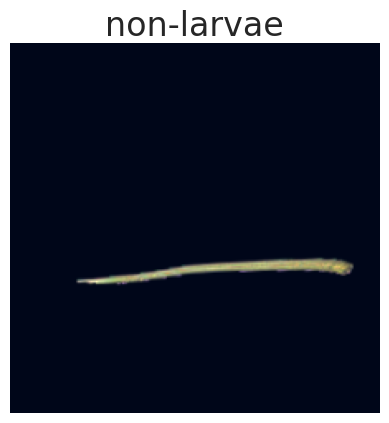

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

lr = 2e-4
eta_min=1e-6
weight_decay=1e-4
# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[32,8],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [11]:
optimizer_cnn_0 = optim.AdamW(cnn_0.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=eta_min)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6902 | Val Loss: 0.6918 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6875 | Val Loss: 0.6890 | Train cohen_kappa_fn: 0.2402 | Val cohen_kappa_fn: 0.0111 | Train f1_fn: 0.8848 | Val f1_fn: 0.8935
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6817 | Val Loss: 0.6821 | Train cohen_kappa_fn: 0.2846 | Val cohen_kappa_fn: 0.2574 | Train f1_fn: 0.8571 | Val f1_fn: 0.9009
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6720 | Val Loss: 0.6679 | Train cohen_kappa_fn: 0.3043 | Val cohen_kappa_fn: 0.3927 | Train f1_fn: 0.8487 | Val f1_fn: 0.8964
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6539 | Val Loss: 0.6455 | Train cohen_kappa_fn: 0.3836 | Val cohen_kappa_fn: 0.4039 | Train f1_fn: 0.8546 | Val f1_fn: 0.8762
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6240 | Val Loss: 0.6166 | Train cohen_kappa_fn: 0.3272 | Val cohen_kappa_fn: 0.3576 | Train f1_fn: 0.7962 | Val f1_fn: 0.8162
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5883 | Val Loss: 0.5782 | Train cohen_kappa_fn: 0.3163 | Val cohen_kappa_fn: 0.3436 | Train f1_fn: 0.7746 | Val f1_fn: 0.7867
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5551 | Val Loss: 0.5522 | Train cohen_kappa_fn: 0.2732 | Val cohen_kappa_fn: 0.2873 | Train f1_fn: 0.7328 | Val f1_fn: 0.7277
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5162 | Val Loss: 0.5234 | Train cohen_kappa_fn: 0.2625 | Val cohen_kappa_fn: 0.2809 | Train f1_fn: 0.7073 | Val f1_fn: 0.7143
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4750 | Val Loss: 0.4508 | Train cohen_kappa_fn: 0.3634 | Val cohen_kappa_fn: 0.4264 | Train f1_fn: 0.7936 | Val f1_fn: 0.8383
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4323 | Val Loss: 0.3812 | Train cohen_kappa_fn: 0.5373 | Val cohen_kappa_fn: 0.6408 | Train f1_fn: 0.8902 | Val f1_fn: 0.9328
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3814 | Val Loss: 0.3852 | Train cohen_kappa_fn: 0.3323 | Val cohen_kappa_fn: 0.4357 | Train f1_fn: 0.7706 | Val f1_fn: 0.8432
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.3586 | Val Loss: 0.3126 | Train cohen_kappa_fn: 0.5929 | Val cohen_kappa_fn: 0.6431 | Train f1_fn: 0.9085 | Val f1_fn: 0.9302
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3404 | Val Loss: 0.5055 | Train cohen_kappa_fn: 0.1829 | Val cohen_kappa_fn: 0.1905 | Train f1_fn: 0.5923 | Val f1_fn: 0.6010
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3093 | Val Loss: 0.3156 | Train cohen_kappa_fn: 0.4227 | Val cohen_kappa_fn: 0.4791 | Train f1_fn: 0.8310 | Val f1_fn: 0.8678
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2831 | Val Loss: 0.2816 | Train cohen_kappa_fn: 0.5368 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.8858 | Val f1_fn: 0.9194
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2680 | Val Loss: 0.2624 | Train cohen_kappa_fn: 0.6230 | Val cohen_kappa_fn: 0.6629 | Train f1_fn: 0.9169 | Val f1_fn: 0.9341
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2351 | Val Loss: 0.3892 | Train cohen_kappa_fn: 0.3344 | Val cohen_kappa_fn: 0.3616 | Train f1_fn: 0.7675 | Val f1_fn: 0.7838
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2576 | Val Loss: 0.2639 | Train cohen_kappa_fn: 0.5620 | Val cohen_kappa_fn: 0.6018 | Train f1_fn: 0.8947 | Val f1_fn: 0.9124
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2425 | Val Loss: 0.2687 | Train cohen_kappa_fn: 0.5527 | Val cohen_kappa_fn: 0.5638 | Train f1_fn: 0.8911 | Val f1_fn: 0.8992
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2067 | Val Loss: 0.2455 | Train cohen_kappa_fn: 0.6975 | Val cohen_kappa_fn: 0.6583 | Train f1_fn: 0.9390 | Val f1_fn: 0.9344
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1919 | Val Loss: 0.2431 | Train cohen_kappa_fn: 0.7147 | Val cohen_kappa_fn: 0.6937 | Train f1_fn: 0.9440 | Val f1_fn: 0.9448
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1864 | Val Loss: 0.2637 | Train cohen_kappa_fn: 0.5435 | Val cohen_kappa_fn: 0.5585 | Train f1_fn: 0.8874 | Val f1_fn: 0.8996
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2152 | Val Loss: 0.2452 | Train cohen_kappa_fn: 0.6375 | Val cohen_kappa_fn: 0.5984 | Train f1_fn: 0.9201 | Val f1_fn: 0.9152
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1727 | Val Loss: 0.2950 | Train cohen_kappa_fn: 0.8408 | Val cohen_kappa_fn: 0.7393 | Train f1_fn: 0.9737 | Val f1_fn: 0.9593
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1833 | Val Loss: 0.2479 | Train cohen_kappa_fn: 0.7356 | Val cohen_kappa_fn: 0.6809 | Train f1_fn: 0.9488 | Val f1_fn: 0.9430
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.2034 | Val Loss: 0.2445 | Train cohen_kappa_fn: 0.7502 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9520 | Val f1_fn: 0.9389
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


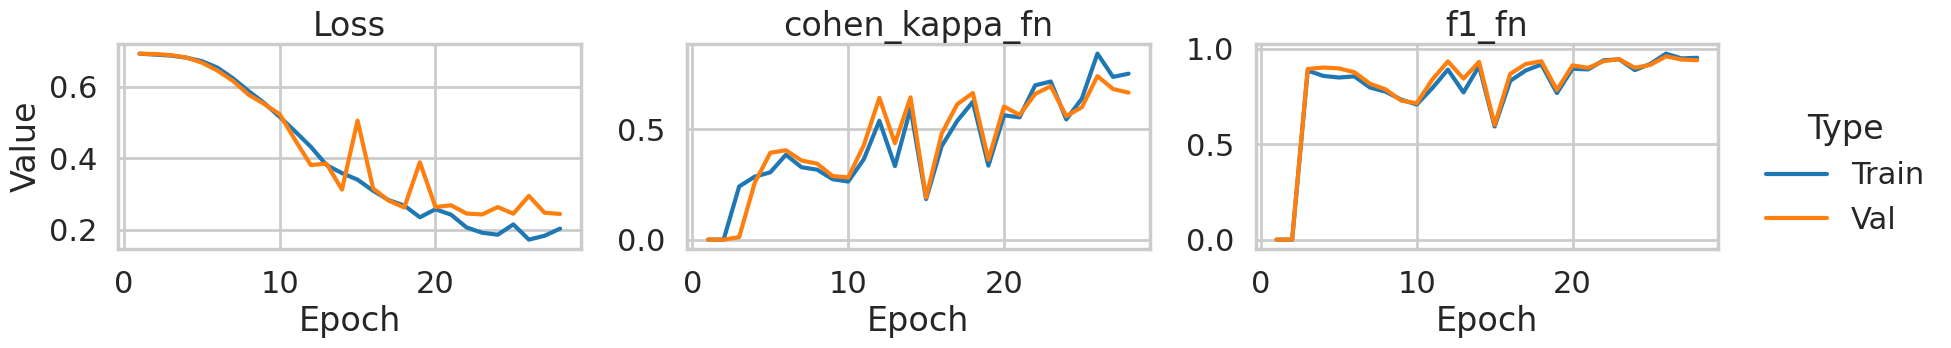

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2018 | Test cohen_kappa_fn: 0.7967 | Test f1_fn: 0.9663


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

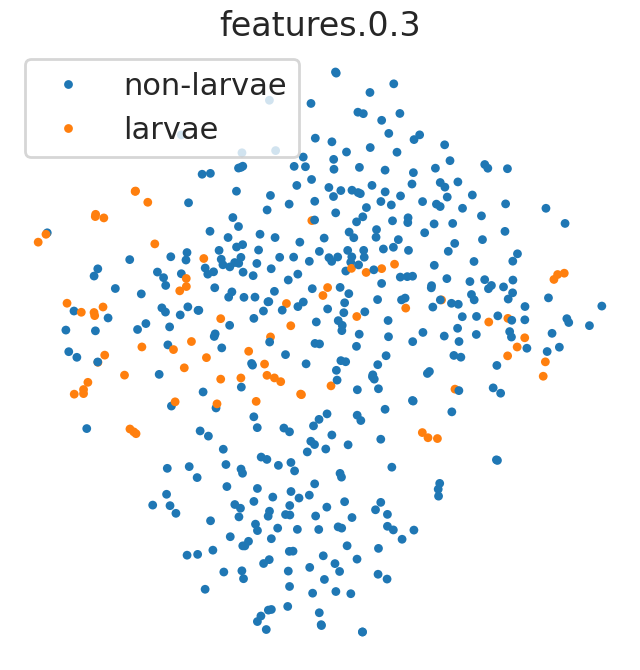

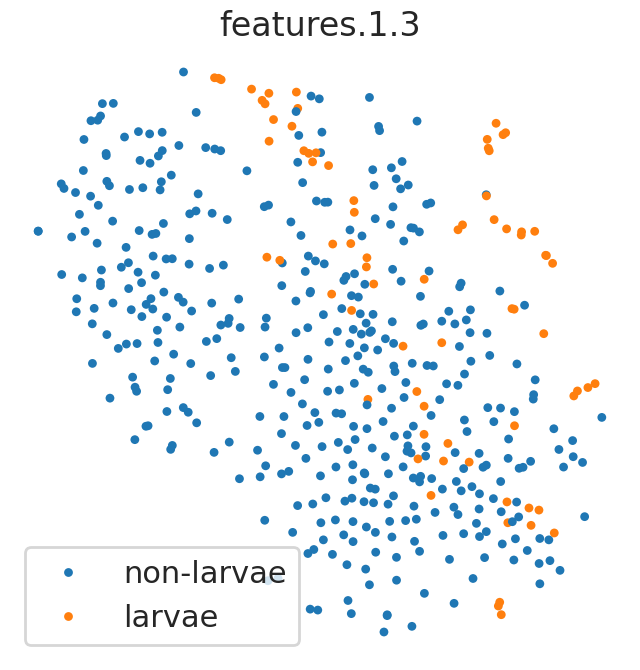

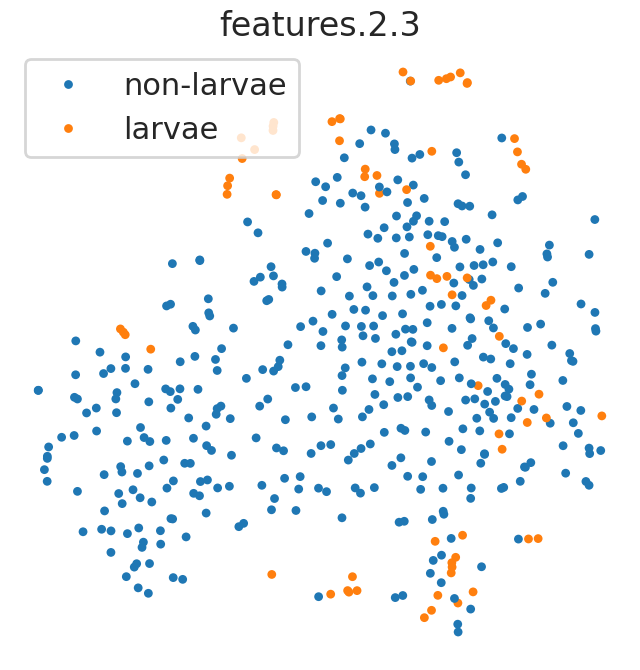

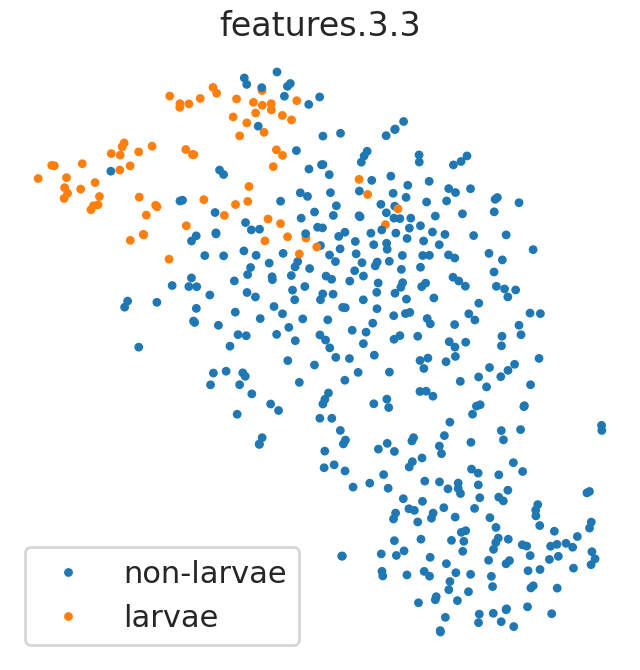

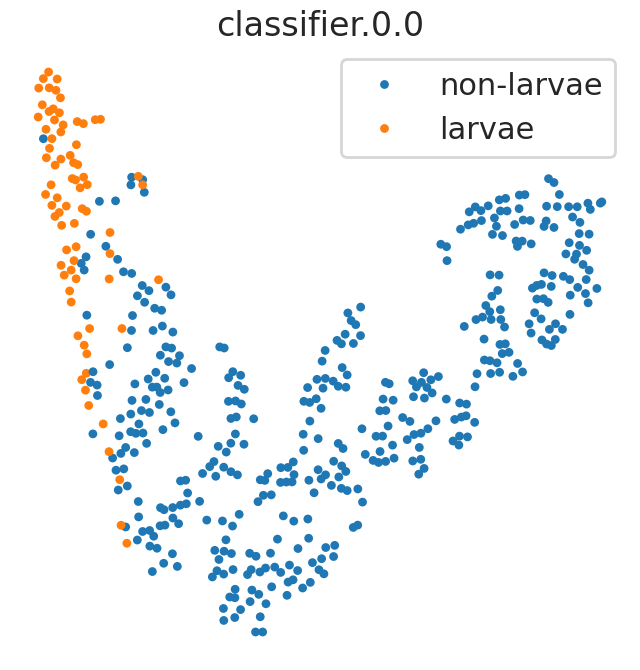

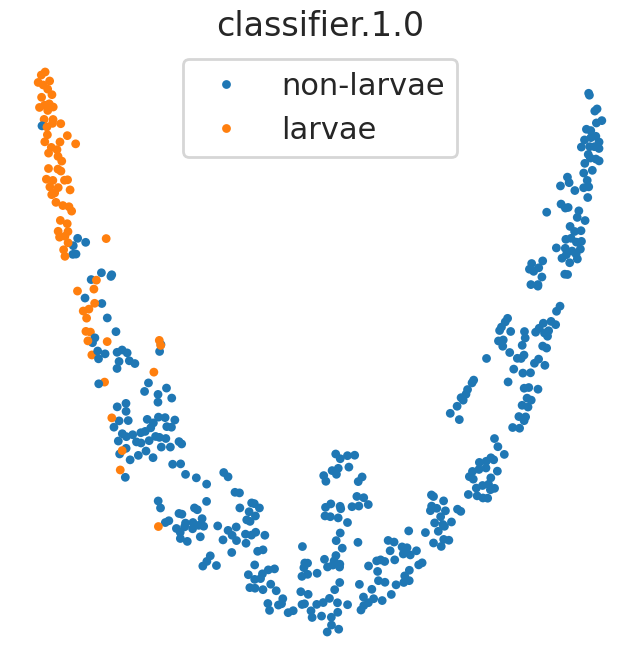

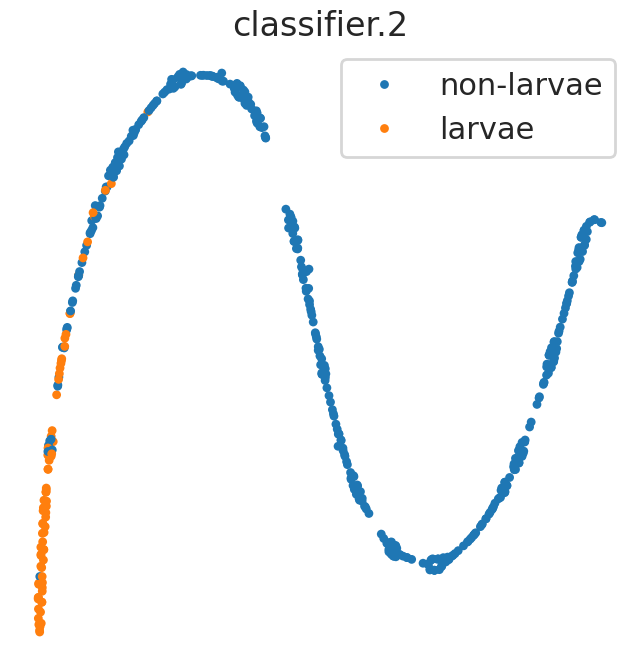

In [16]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


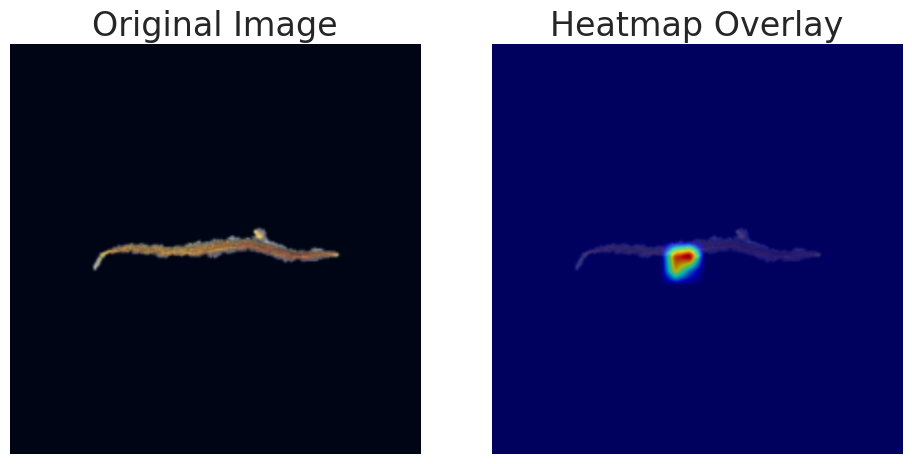

  Generating heatmap for Larvae...
  Predicted label is Larvae!


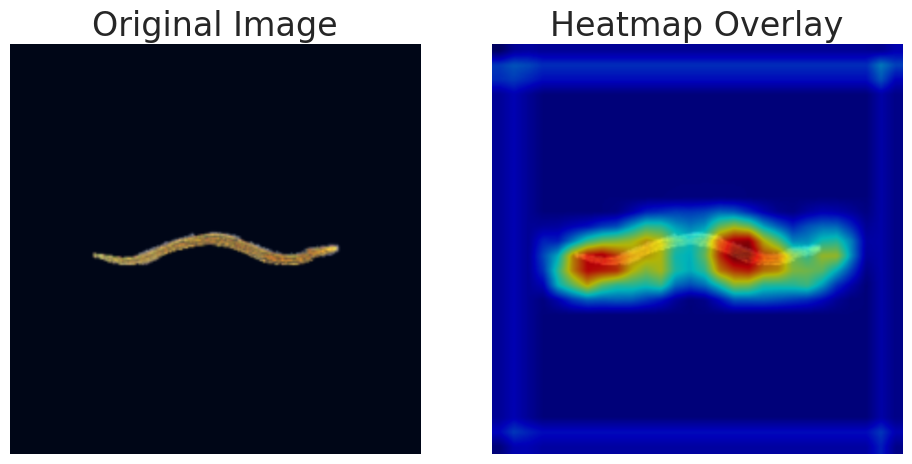

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [18]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[32,16],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [19]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=eta_min)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [20]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6917 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0861 | Val cohen_kappa_fn: 0.2235 | Train f1_fn: 0.5958 | Val f1_fn: 0.8415
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6903 | Val Loss: 0.6915 | Train cohen_kappa_fn: 0.0169 | Val cohen_kappa_fn: 0.0930 | Train f1_fn: 0.1671 | Val f1_fn: 0.4152
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6881 | Val Loss: 0.6881 | Train cohen_kappa_fn: 0.0355 | Val cohen_kappa_fn: 0.1314 | Train f1_fn: 0.2497 | Val f1_fn: 0.5217
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6820 | Val Loss: 0.6802 | Train cohen_kappa_fn: 0.0751 | Val cohen_kappa_fn: 0.1893 | Train f1_fn: 0.3795 | Val f1_fn: 0.6103
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6684 | Val Loss: 0.6650 | Train cohen_kappa_fn: 0.1917 | Val cohen_kappa_fn: 0.2913 | Train f1_fn: 0.6647 | Val f1_fn: 0.7517
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6510 | Val Loss: 0.6355 | Train cohen_kappa_fn: 0.1406 | Val cohen_kappa_fn: 0.1293 | Train f1_fn: 0.5208 | Val f1_fn: 0.4874
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6111 | Val Loss: 0.5880 | Train cohen_kappa_fn: 0.1539 | Val cohen_kappa_fn: 0.1332 | Train f1_fn: 0.5574 | Val f1_fn: 0.4958
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5544 | Val Loss: 0.5130 | Train cohen_kappa_fn: 0.3682 | Val cohen_kappa_fn: 0.3573 | Train f1_fn: 0.8108 | Val f1_fn: 0.7911
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4879 | Val Loss: 0.4341 | Train cohen_kappa_fn: 0.4990 | Val cohen_kappa_fn: 0.5172 | Train f1_fn: 0.8768 | Val f1_fn: 0.8811
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4223 | Val Loss: 0.4016 | Train cohen_kappa_fn: 0.3782 | Val cohen_kappa_fn: 0.3650 | Train f1_fn: 0.8094 | Val f1_fn: 0.7965
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3881 | Val Loss: 0.3271 | Train cohen_kappa_fn: 0.7045 | Val cohen_kappa_fn: 0.6748 | Train f1_fn: 0.9494 | Val f1_fn: 0.9456
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3280 | Val Loss: 0.2915 | Train cohen_kappa_fn: 0.7355 | Val cohen_kappa_fn: 0.6678 | Train f1_fn: 0.9527 | Val f1_fn: 0.9412
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3091 | Val Loss: 0.2728 | Train cohen_kappa_fn: 0.6733 | Val cohen_kappa_fn: 0.6660 | Train f1_fn: 0.9363 | Val f1_fn: 0.9364
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3025 | Val Loss: 0.4681 | Train cohen_kappa_fn: 0.2651 | Val cohen_kappa_fn: 0.2518 | Train f1_fn: 0.7037 | Val f1_fn: 0.6829
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2526 | Val Loss: 0.2563 | Train cohen_kappa_fn: 0.6861 | Val cohen_kappa_fn: 0.6726 | Train f1_fn: 0.9386 | Val f1_fn: 0.9410
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2351 | Val Loss: 0.2522 | Train cohen_kappa_fn: 0.7308 | Val cohen_kappa_fn: 0.6408 | Train f1_fn: 0.9481 | Val f1_fn: 0.9328
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2357 | Val Loss: 0.2892 | Train cohen_kappa_fn: 0.5256 | Val cohen_kappa_fn: 0.5463 | Train f1_fn: 0.8812 | Val f1_fn: 0.8952
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2283 | Val Loss: 0.2637 | Train cohen_kappa_fn: 0.5744 | Val cohen_kappa_fn: 0.5825 | Train f1_fn: 0.9002 | Val f1_fn: 0.9058
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2341 | Val Loss: 0.2354 | Train cohen_kappa_fn: 0.7762 | Val cohen_kappa_fn: 0.7021 | Train f1_fn: 0.9585 | Val f1_fn: 0.9468
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2016 | Val Loss: 0.2863 | Train cohen_kappa_fn: 0.8005 | Val cohen_kappa_fn: 0.7508 | Train f1_fn: 0.9670 | Val f1_fn: 0.9634
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2146 | Val Loss: 0.2357 | Train cohen_kappa_fn: 0.5957 | Val cohen_kappa_fn: 0.6381 | Train f1_fn: 0.9061 | Val f1_fn: 0.9255
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1994 | Val Loss: 0.2418 | Train cohen_kappa_fn: 0.7940 | Val cohen_kappa_fn: 0.7531 | Train f1_fn: 0.9635 | Val f1_fn: 0.9610
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1777 | Val Loss: 0.2170 | Train cohen_kappa_fn: 0.6648 | Val cohen_kappa_fn: 0.7281 | Train f1_fn: 0.9298 | Val f1_fn: 0.9527
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1922 | Val Loss: 0.2253 | Train cohen_kappa_fn: 0.6977 | Val cohen_kappa_fn: 0.7552 | Train f1_fn: 0.9379 | Val f1_fn: 0.9586
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1717 | Val Loss: 0.2523 | Train cohen_kappa_fn: 0.8153 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9682 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1682 | Val Loss: 0.2074 | Train cohen_kappa_fn: 0.6366 | Val cohen_kappa_fn: 0.6985 | Train f1_fn: 0.9191 | Val f1_fn: 0.9421
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.1712 | Val Loss: 0.2661 | Train cohen_kappa_fn: 0.8408 | Val cohen_kappa_fn: 0.7612 | Train f1_fn: 0.9737 | Val f1_fn: 0.9653
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1681 | Val Loss: 0.2078 | Train cohen_kappa_fn: 0.7589 | Val cohen_kappa_fn: 0.7836 | Train f1_fn: 0.9545 | Val f1_fn: 0.9645
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1429 | Val Loss: 0.3091 | Train cohen_kappa_fn: 0.9007 | Val cohen_kappa_fn: 0.7464 | Train f1_fn: 0.9844 | Val f1_fn: 0.9635
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1579 | Val Loss: 0.2532 | Train cohen_kappa_fn: 0.8388 | Val cohen_kappa_fn: 0.8040 | Train f1_fn: 0.9729 | Val f1_fn: 0.9706
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1569 | Val Loss: 0.2111 | Train cohen_kappa_fn: 0.7549 | Val cohen_kappa_fn: 0.7740 | Train f1_fn: 0.9527 | Val f1_fn: 0.9625
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


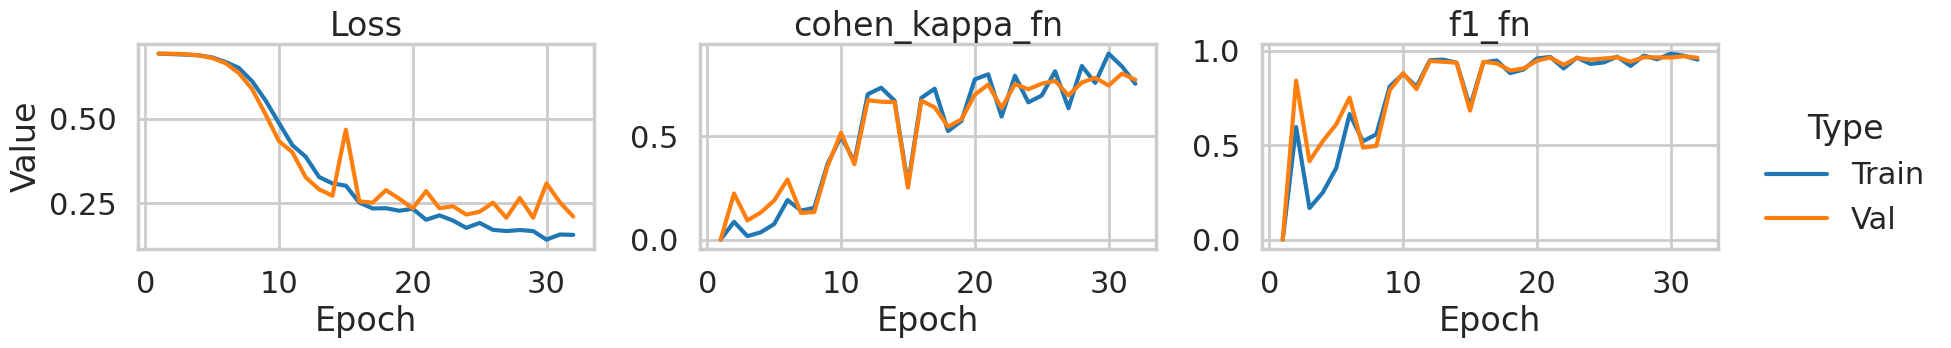

In [21]:
trainer_cnn_1.plot_epochs()

In [22]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1869 | Test cohen_kappa_fn: 0.7122 | Test f1_fn: 0.9447


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

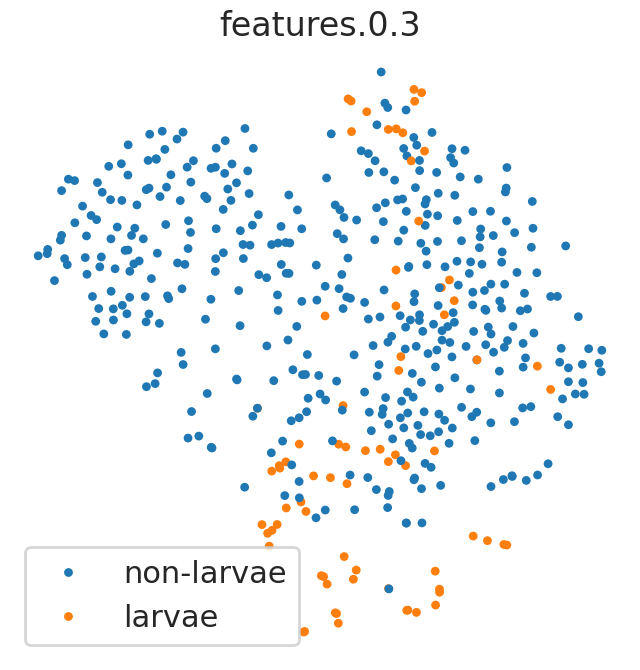

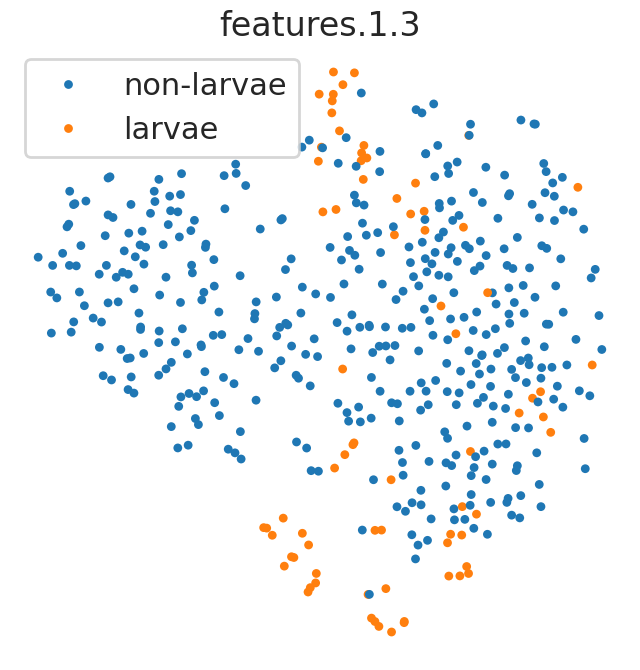

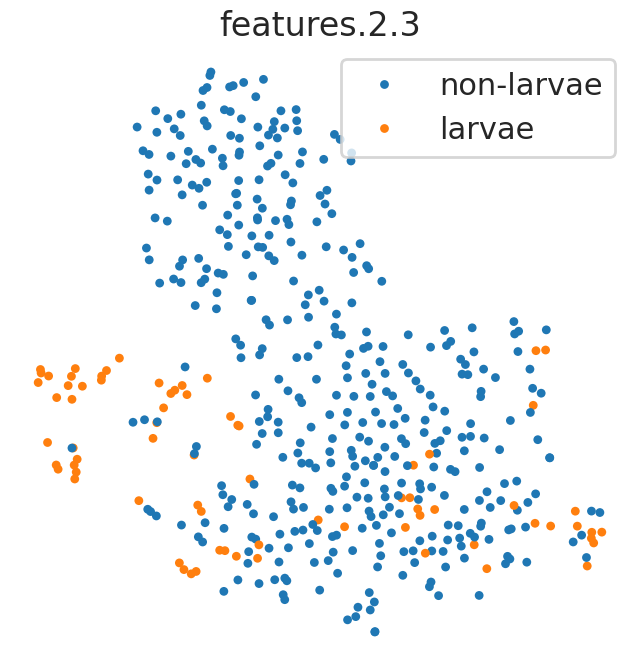

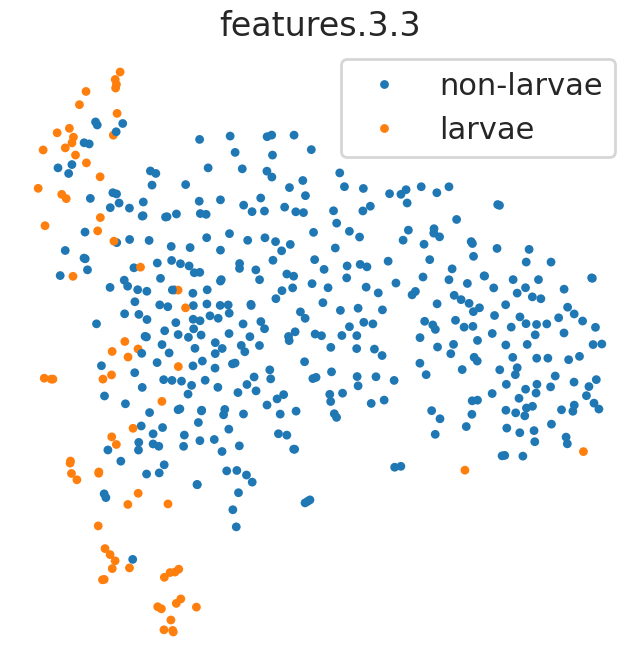

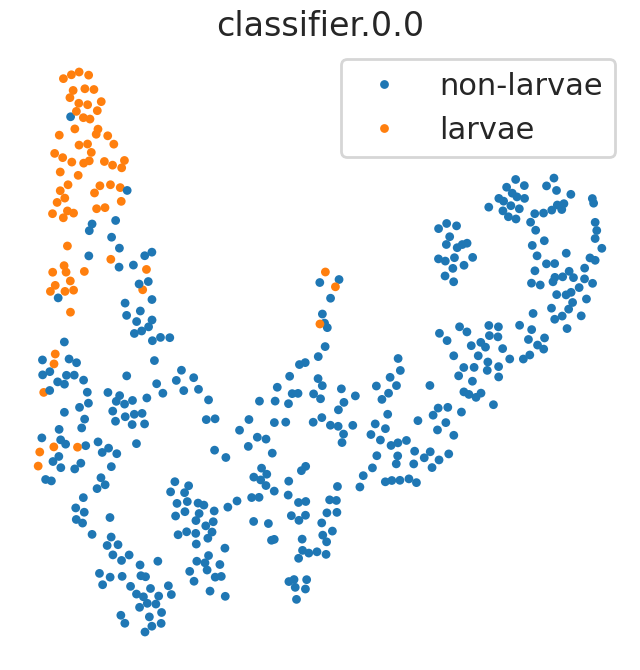

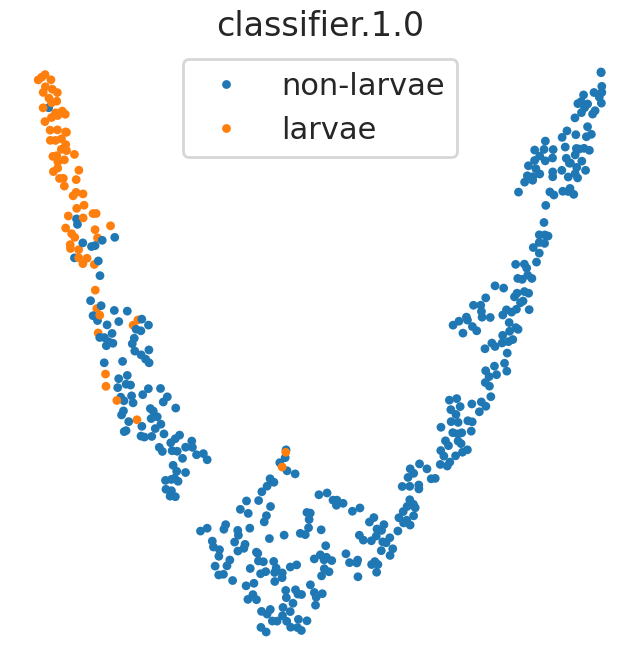

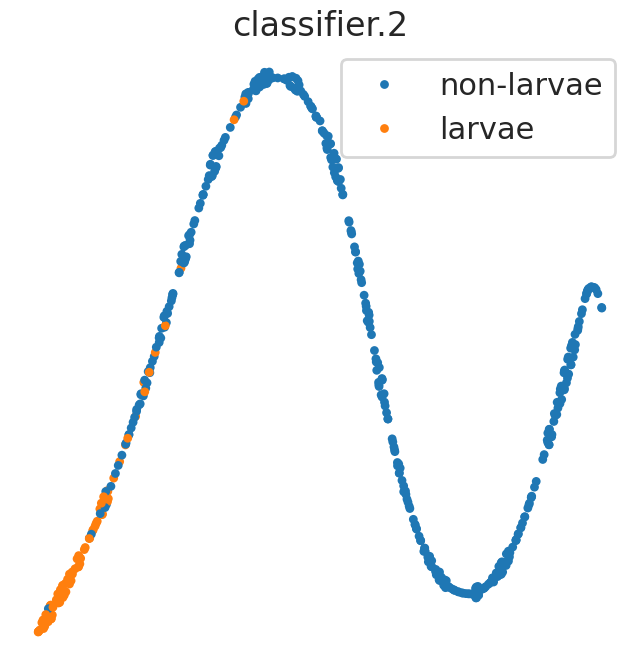

In [24]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


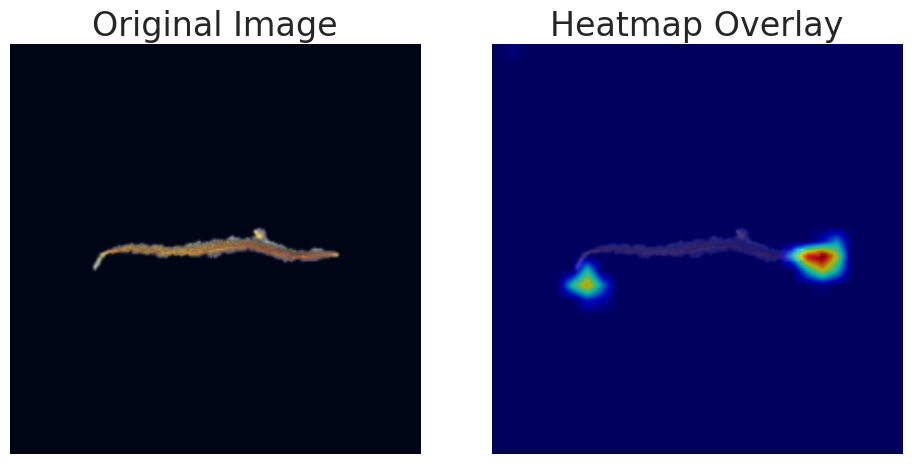

  Generating heatmap for Larvae...
  Predicted label is Larvae!


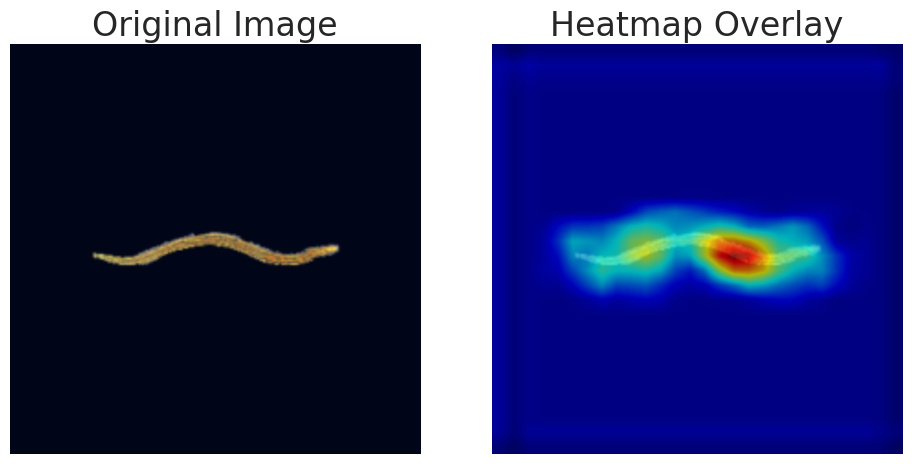

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [26]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,8],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [27]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=eta_min)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [28]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6926 | Val Loss: 0.6928 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6889 | Val Loss: 0.6915 | Train cohen_kappa_fn: 0.1489 | Val cohen_kappa_fn: 0.0254 | Train f1_fn: 0.7895 | Val f1_fn: 0.7976
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6833 | Val Loss: 0.6873 | Train cohen_kappa_fn: 0.1444 | Val cohen_kappa_fn: 0.1060 | Train f1_fn: 0.7415 | Val f1_fn: 0.7553
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6749 | Val Loss: 0.6800 | Train cohen_kappa_fn: 0.1212 | Val cohen_kappa_fn: 0.1140 | Train f1_fn: 0.4917 | Val f1_fn: 0.4847
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6526 | Val Loss: 0.6601 | Train cohen_kappa_fn: 0.1794 | Val cohen_kappa_fn: 0.1529 | Train f1_fn: 0.6362 | Val f1_fn: 0.5876
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6249 | Val Loss: 0.6297 | Train cohen_kappa_fn: 0.1858 | Val cohen_kappa_fn: 0.1436 | Train f1_fn: 0.6193 | Val f1_fn: 0.5455
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5944 | Val Loss: 0.5838 | Train cohen_kappa_fn: 0.3154 | Val cohen_kappa_fn: 0.2815 | Train f1_fn: 0.7787 | Val f1_fn: 0.7431
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5519 | Val Loss: 0.5375 | Train cohen_kappa_fn: 0.3621 | Val cohen_kappa_fn: 0.3154 | Train f1_fn: 0.8128 | Val f1_fn: 0.7713
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5178 | Val Loss: 0.4978 | Train cohen_kappa_fn: 0.2926 | Val cohen_kappa_fn: 0.2780 | Train f1_fn: 0.7530 | Val f1_fn: 0.7187
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4516 | Val Loss: 0.4580 | Train cohen_kappa_fn: 0.3002 | Val cohen_kappa_fn: 0.2964 | Train f1_fn: 0.7516 | Val f1_fn: 0.7294
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4360 | Val Loss: 0.4531 | Train cohen_kappa_fn: 0.2794 | Val cohen_kappa_fn: 0.2249 | Train f1_fn: 0.7273 | Val f1_fn: 0.6500
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3908 | Val Loss: 0.5742 | Train cohen_kappa_fn: 0.1740 | Val cohen_kappa_fn: 0.1181 | Train f1_fn: 0.5774 | Val f1_fn: 0.4615
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3307 | Val Loss: 0.3329 | Train cohen_kappa_fn: 0.5436 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.8885 | Val f1_fn: 0.8974
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3250 | Val Loss: 0.4965 | Train cohen_kappa_fn: 0.2481 | Val cohen_kappa_fn: 0.1905 | Train f1_fn: 0.6816 | Val f1_fn: 0.6010
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2914 | Val Loss: 0.2801 | Train cohen_kappa_fn: 0.7288 | Val cohen_kappa_fn: 0.7193 | Train f1_fn: 0.9521 | Val f1_fn: 0.9508
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2837 | Val Loss: 0.3715 | Train cohen_kappa_fn: 0.4146 | Val cohen_kappa_fn: 0.3483 | Train f1_fn: 0.8247 | Val f1_fn: 0.7793
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2471 | Val Loss: 0.2492 | Train cohen_kappa_fn: 0.7525 | Val cohen_kappa_fn: 0.6863 | Train f1_fn: 0.9558 | Val f1_fn: 0.9403
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2678 | Val Loss: 0.4413 | Train cohen_kappa_fn: 0.3472 | Val cohen_kappa_fn: 0.2749 | Train f1_fn: 0.7776 | Val f1_fn: 0.7081
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2087 | Val Loss: 0.2736 | Train cohen_kappa_fn: 0.6313 | Val cohen_kappa_fn: 0.5953 | Train f1_fn: 0.9174 | Val f1_fn: 0.9102
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2558 | Val Loss: 0.2681 | Train cohen_kappa_fn: 0.5969 | Val cohen_kappa_fn: 0.6018 | Train f1_fn: 0.9082 | Val f1_fn: 0.9124
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1939 | Val Loss: 0.2437 | Train cohen_kappa_fn: 0.6701 | Val cohen_kappa_fn: 0.6357 | Train f1_fn: 0.9325 | Val f1_fn: 0.9231
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1972 | Val Loss: 0.2216 | Train cohen_kappa_fn: 0.7879 | Val cohen_kappa_fn: 0.7274 | Train f1_fn: 0.9618 | Val f1_fn: 0.9504
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1950 | Val Loss: 0.2220 | Train cohen_kappa_fn: 0.7162 | Val cohen_kappa_fn: 0.6948 | Train f1_fn: 0.9429 | Val f1_fn: 0.9398
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1655 | Val Loss: 0.2207 | Train cohen_kappa_fn: 0.8060 | Val cohen_kappa_fn: 0.6981 | Train f1_fn: 0.9648 | Val f1_fn: 0.9446
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1888 | Val Loss: 0.2266 | Train cohen_kappa_fn: 0.7193 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9437 | Val f1_fn: 0.9315
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1681 | Val Loss: 0.2285 | Train cohen_kappa_fn: 0.7797 | Val cohen_kappa_fn: 0.6899 | Train f1_fn: 0.9593 | Val f1_fn: 0.9425
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2002 | Val Loss: 0.2473 | Train cohen_kappa_fn: 0.6917 | Val cohen_kappa_fn: 0.6310 | Train f1_fn: 0.9363 | Val f1_fn: 0.9234
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1826 | Val Loss: 0.2533 | Train cohen_kappa_fn: 0.8655 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9783 | Val f1_fn: 0.9591
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1630 | Val Loss: 0.2249 | Train cohen_kappa_fn: 0.8301 | Val cohen_kappa_fn: 0.7193 | Train f1_fn: 0.9704 | Val f1_fn: 0.9508
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


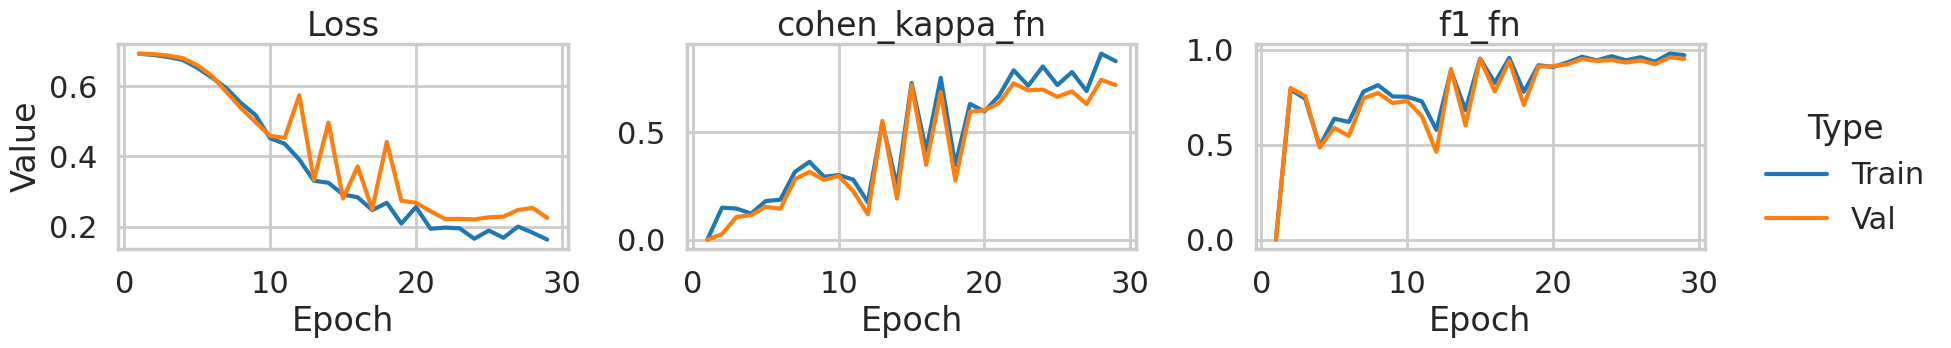

In [29]:
trainer_cnn_2.plot_epochs()

In [30]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1938 | Test cohen_kappa_fn: 0.8202 | Test f1_fn: 0.9700


#### Visualization

In [31]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

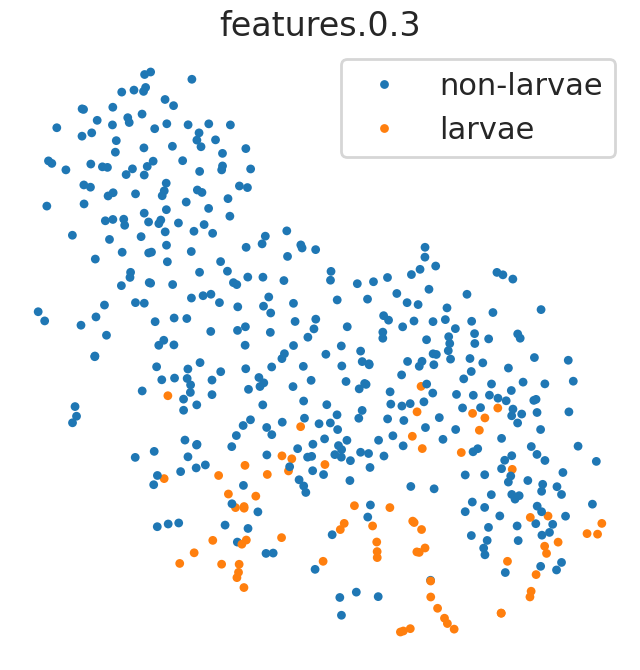

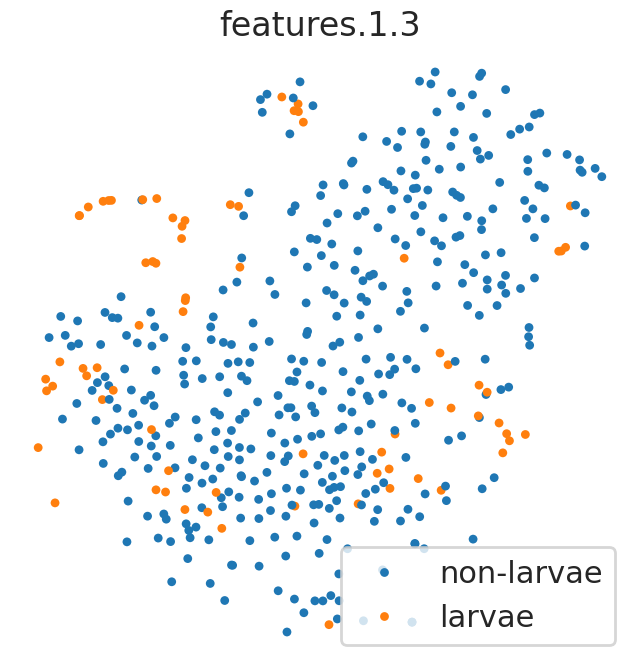

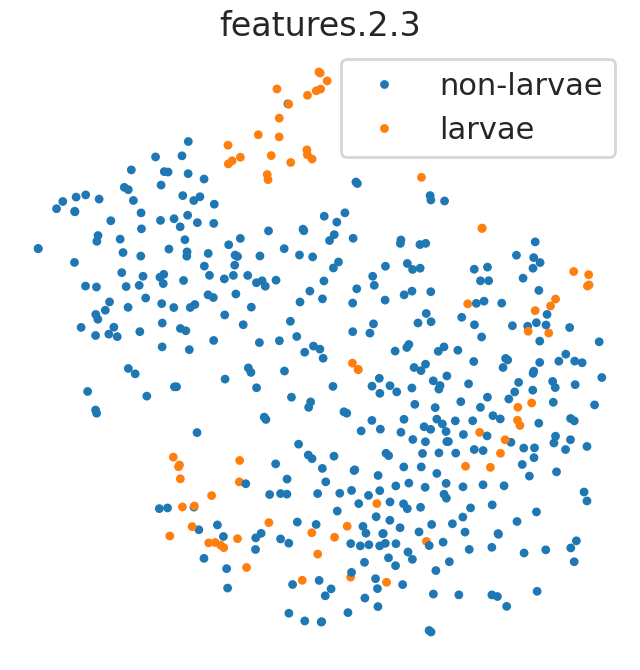

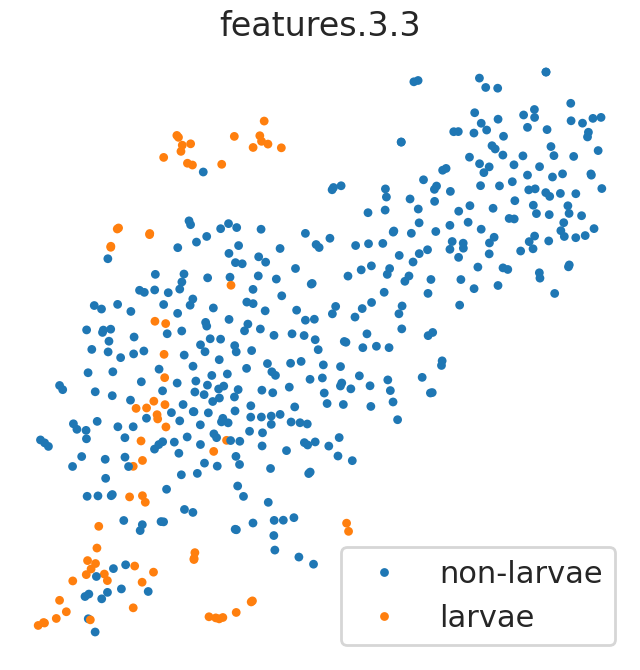

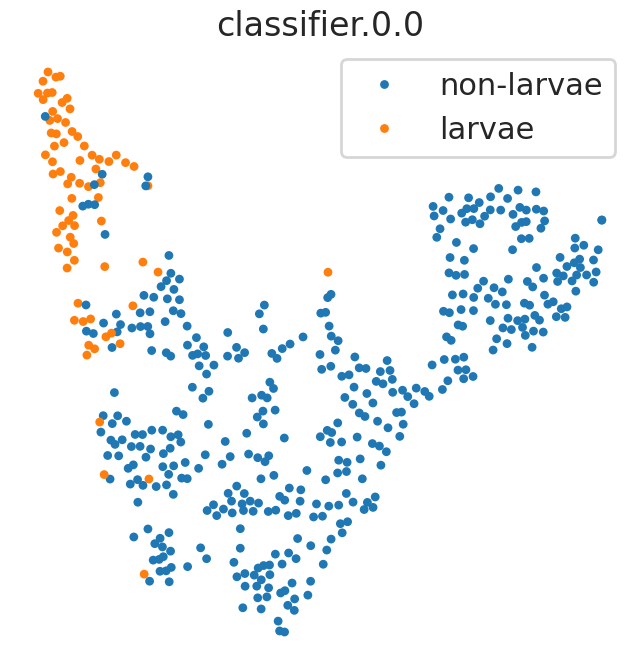

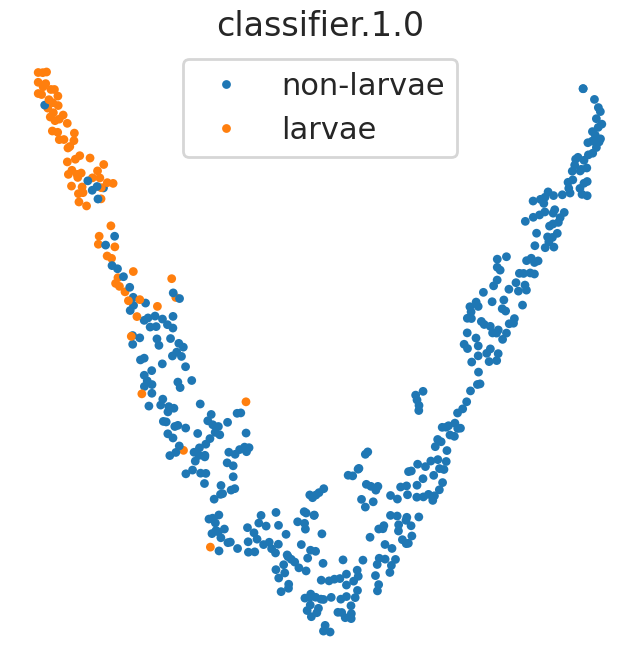

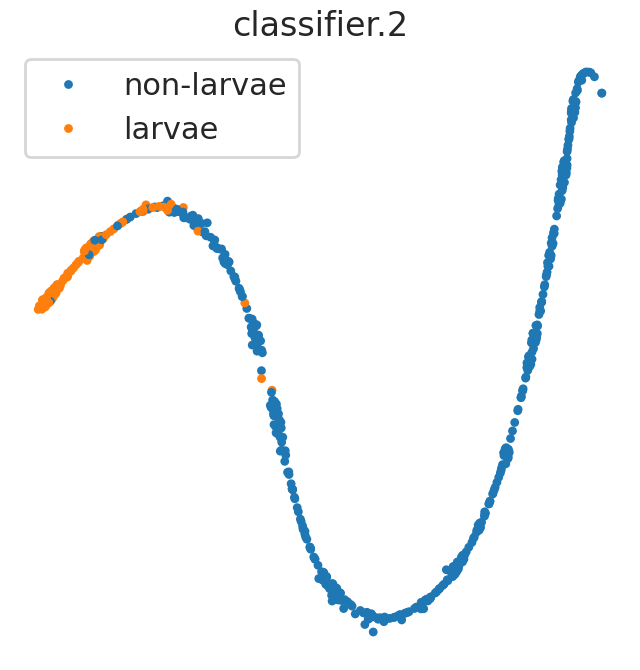

In [32]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


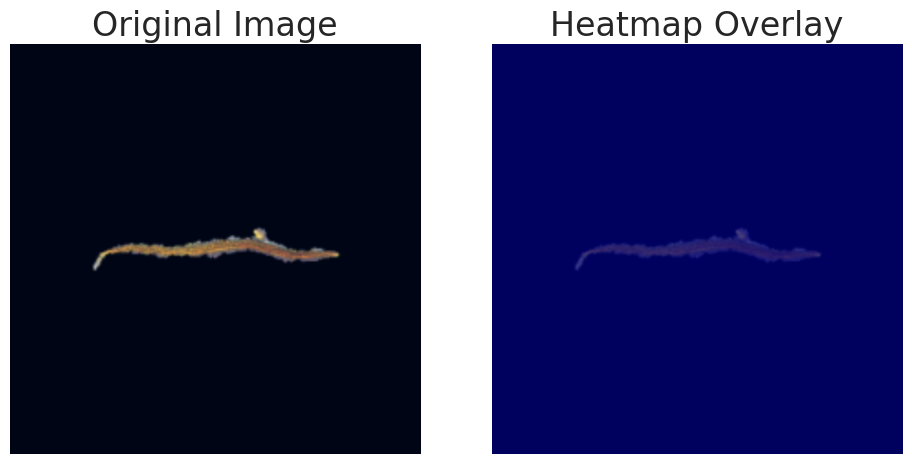

  Generating heatmap for Larvae...
  Predicted label is Larvae!


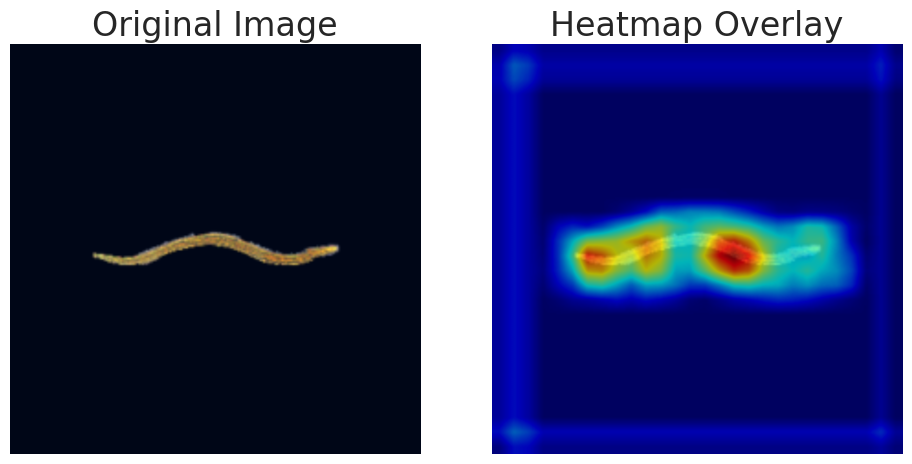

In [33]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [34]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64,16],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [35]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=eta_min)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [36]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6930 | Val Loss: 0.6930 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6918 | Val Loss: 0.6922 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6888 | Val Loss: 0.6893 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6827 | Val Loss: 0.6834 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6720 | Val Loss: 0.6692 | Train cohen_kappa_fn: 0.0328 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9131 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6537 | Val Loss: 0.6474 | Train cohen_kappa_fn: 0.3572 | Val cohen_kappa_fn: 0.3084 | Train f1_fn: 0.8555 | Val f1_fn: 0.8515
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6233 | Val Loss: 0.6147 | Train cohen_kappa_fn: 0.3488 | Val cohen_kappa_fn: 0.3452 | Train f1_fn: 0.8551 | Val f1_fn: 0.8594
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5939 | Val Loss: 0.5879 | Train cohen_kappa_fn: 0.3375 | Val cohen_kappa_fn: 0.3618 | Train f1_fn: 0.8072 | Val f1_fn: 0.8188
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5571 | Val Loss: 0.5819 | Train cohen_kappa_fn: 0.2318 | Val cohen_kappa_fn: 0.2321 | Train f1_fn: 0.6903 | Val f1_fn: 0.6683
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5244 | Val Loss: 0.5667 | Train cohen_kappa_fn: 0.1979 | Val cohen_kappa_fn: 0.1859 | Train f1_fn: 0.6324 | Val f1_fn: 0.5938
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4840 | Val Loss: 0.6392 | Train cohen_kappa_fn: 0.1029 | Val cohen_kappa_fn: 0.0648 | Train f1_fn: 0.4266 | Val f1_fn: 0.3072
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4203 | Val Loss: 0.4115 | Train cohen_kappa_fn: 0.3999 | Val cohen_kappa_fn: 0.3671 | Train f1_fn: 0.8228 | Val f1_fn: 0.7929
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3740 | Val Loss: 0.7581 | Train cohen_kappa_fn: 0.0526 | Val cohen_kappa_fn: 0.0336 | Train f1_fn: 0.2648 | Val f1_fn: 0.1818
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.3387 | Val Loss: 0.4407 | Train cohen_kappa_fn: 0.3141 | Val cohen_kappa_fn: 0.2463 | Train f1_fn: 0.7532 | Val f1_fn: 0.6765
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2766 | Val Loss: 0.5266 | Train cohen_kappa_fn: 0.2698 | Val cohen_kappa_fn: 0.1882 | Train f1_fn: 0.7057 | Val f1_fn: 0.5974
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2579 | Val Loss: 0.2496 | Train cohen_kappa_fn: 0.6898 | Val cohen_kappa_fn: 0.6219 | Train f1_fn: 0.9374 | Val f1_fn: 0.9188
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2165 | Val Loss: 0.3260 | Train cohen_kappa_fn: 0.4603 | Val cohen_kappa_fn: 0.4304 | Train f1_fn: 0.8484 | Val f1_fn: 0.8286
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1837 | Val Loss: 0.2447 | Train cohen_kappa_fn: 0.8470 | Val cohen_kappa_fn: 0.7668 | Train f1_fn: 0.9754 | Val f1_fn: 0.9628
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1810 | Val Loss: 0.2236 | Train cohen_kappa_fn: 0.8252 | Val cohen_kappa_fn: 0.7802 | Train f1_fn: 0.9697 | Val f1_fn: 0.9646
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1674 | Val Loss: 0.1997 | Train cohen_kappa_fn: 0.7679 | Val cohen_kappa_fn: 0.7775 | Train f1_fn: 0.9570 | Val f1_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.1833 | Val Loss: 0.1931 | Train cohen_kappa_fn: 0.8138 | Val cohen_kappa_fn: 0.8344 | Train f1_fn: 0.9674 | Val f1_fn: 0.9718
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1528 | Val Loss: 0.1875 | Train cohen_kappa_fn: 0.7718 | Val cohen_kappa_fn: 0.7814 | Train f1_fn: 0.9568 | Val f1_fn: 0.9598
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1430 | Val Loss: 0.1979 | Train cohen_kappa_fn: 0.6947 | Val cohen_kappa_fn: 0.6912 | Train f1_fn: 0.9371 | Val f1_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1379 | Val Loss: 0.1779 | Train cohen_kappa_fn: 0.7832 | Val cohen_kappa_fn: 0.8151 | Train f1_fn: 0.9601 | Val f1_fn: 0.9679
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1309 | Val Loss: 0.3452 | Train cohen_kappa_fn: 0.8957 | Val cohen_kappa_fn: 0.7612 | Train f1_fn: 0.9837 | Val f1_fn: 0.9653
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1440 | Val Loss: 0.2029 | Train cohen_kappa_fn: 0.8475 | Val cohen_kappa_fn: 0.7997 | Train f1_fn: 0.9735 | Val f1_fn: 0.9662
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1430 | Val Loss: 0.2327 | Train cohen_kappa_fn: 0.8477 | Val cohen_kappa_fn: 0.8033 | Train f1_fn: 0.9744 | Val f1_fn: 0.9683
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1357 | Val Loss: 0.2331 | Train cohen_kappa_fn: 0.8665 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9774 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1175 | Val Loss: 0.1740 | Train cohen_kappa_fn: 0.7857 | Val cohen_kappa_fn: 0.8151 | Train f1_fn: 0.9600 | Val f1_fn: 0.9679
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.1445 | Val Loss: 0.1984 | Train cohen_kappa_fn: 0.6636 | Val cohen_kappa_fn: 0.6836 | Train f1_fn: 0.9288 | Val f1_fn: 0.9354
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1272 | Val Loss: 0.1845 | Train cohen_kappa_fn: 0.8625 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9766 | Val f1_fn: 0.9699
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1413 | Val Loss: 0.3396 | Train cohen_kappa_fn: 0.9032 | Val cohen_kappa_fn: 0.7612 | Train f1_fn: 0.9852 | Val f1_fn: 0.9653
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1392 | Val Loss: 0.1878 | Train cohen_kappa_fn: 0.7663 | Val cohen_kappa_fn: 0.6952 | Train f1_fn: 0.9551 | Val f1_fn: 0.9373
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1206 | Val Loss: 0.3166 | Train cohen_kappa_fn: 0.5190 | Val cohen_kappa_fn: 0.4809 | Train f1_fn: 0.8750 | Val f1_fn: 0.8589
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


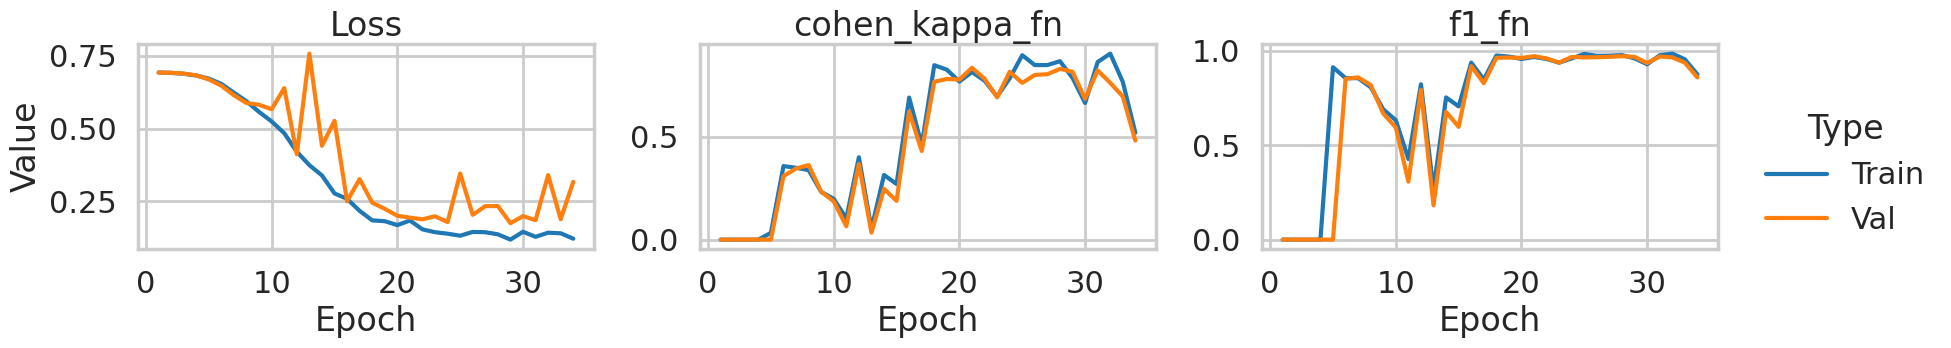

In [37]:
trainer_cnn_3.plot_epochs()

In [38]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1679 | Test cohen_kappa_fn: 0.7863 | Test f1_fn: 0.9620


#### Visualization

In [39]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

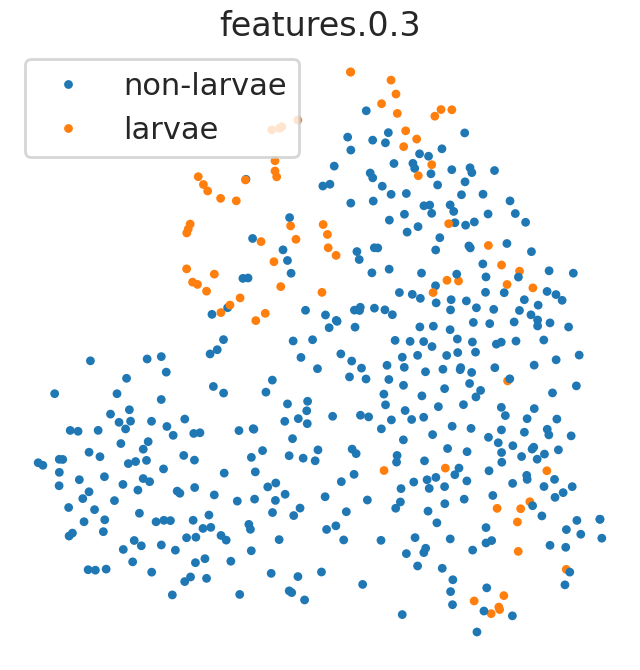

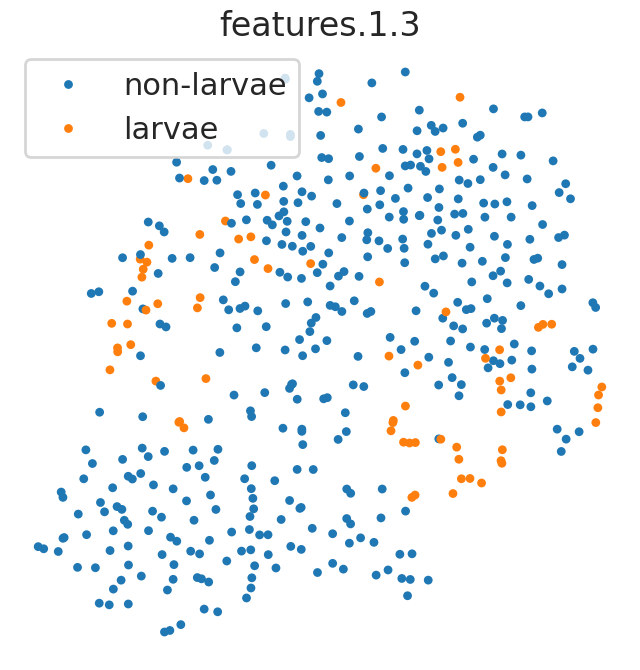

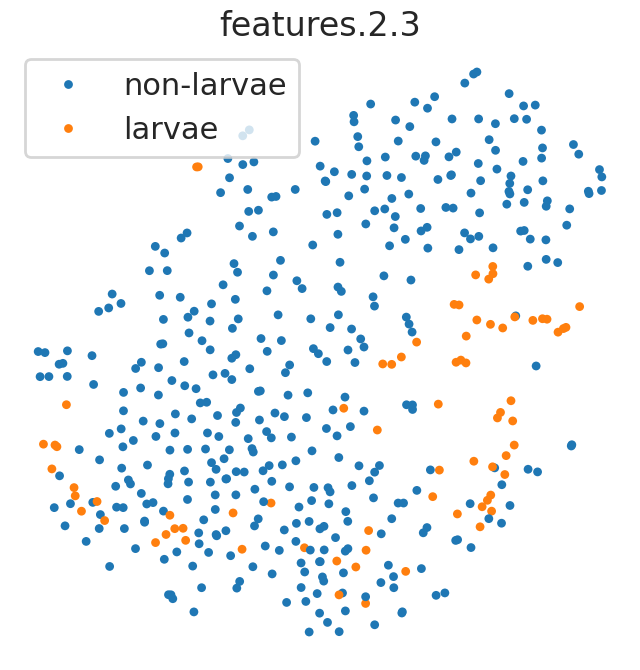

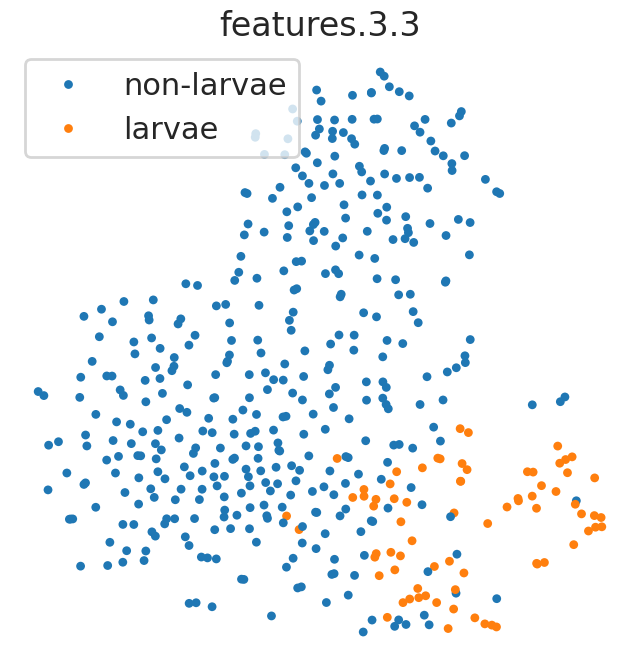

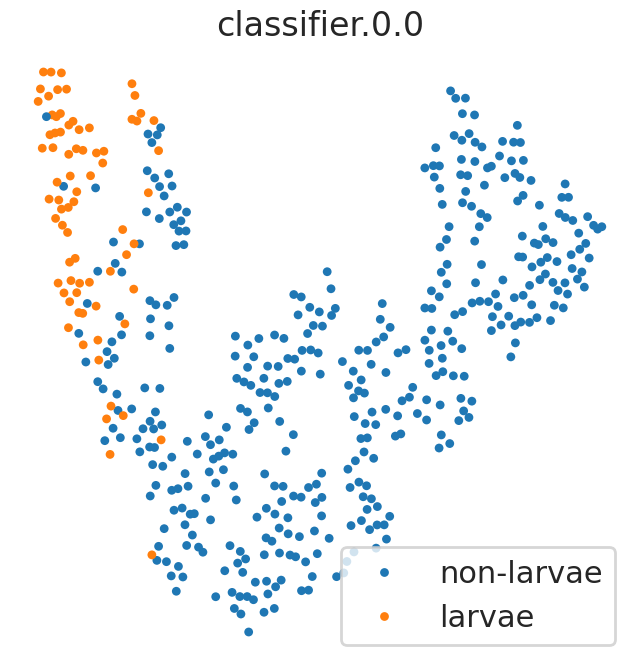

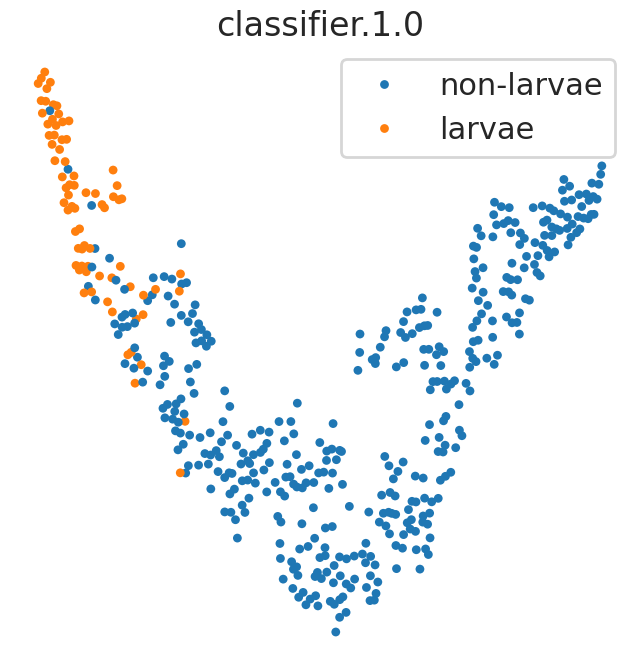

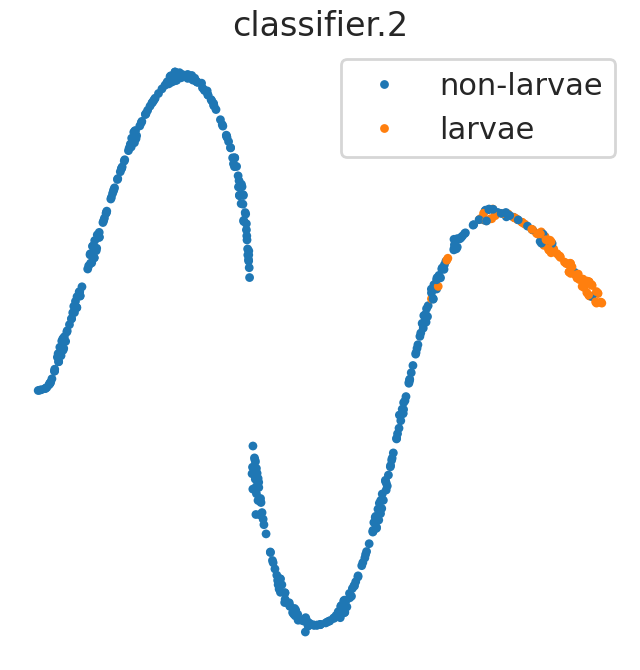

In [40]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


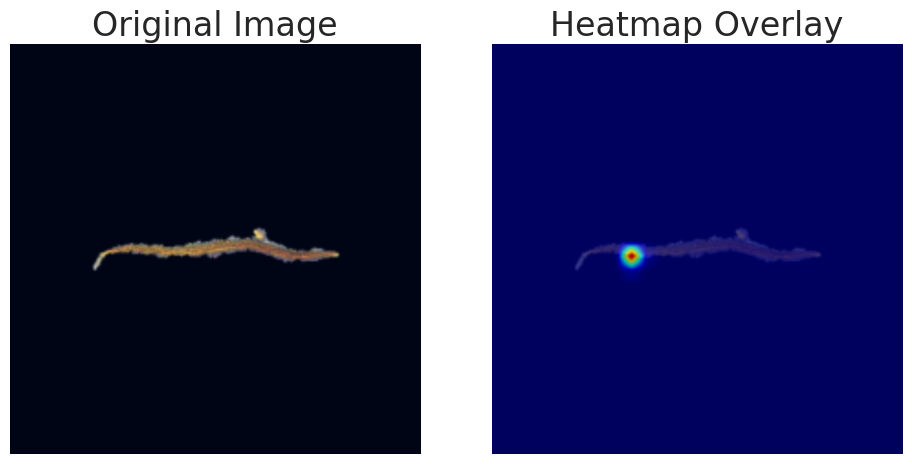

  Generating heatmap for Larvae...
  Predicted label is Larvae!


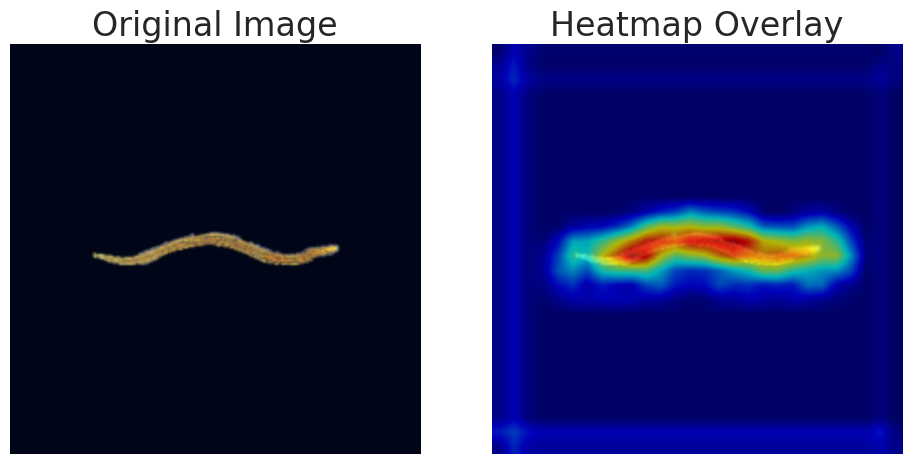

In [41]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [42]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128,8],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [43]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=eta_min)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [44]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6916 | Val Loss: 0.6926 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6909 | Val Loss: 0.6900 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6818 | Val Loss: 0.6838 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6665 | Val Loss: 0.6684 | Train cohen_kappa_fn: 0.1613 | Val cohen_kappa_fn: 0.0142 | Train f1_fn: 0.9081 | Val f1_fn: 0.9113
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6451 | Val Loss: 0.6403 | Train cohen_kappa_fn: 0.3275 | Val cohen_kappa_fn: 0.2571 | Train f1_fn: 0.8295 | Val f1_fn: 0.8471
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6098 | Val Loss: 0.6081 | Train cohen_kappa_fn: 0.3290 | Val cohen_kappa_fn: 0.3817 | Train f1_fn: 0.8142 | Val f1_fn: 0.8513
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5800 | Val Loss: 0.6108 | Train cohen_kappa_fn: 0.1940 | Val cohen_kappa_fn: 0.2268 | Train f1_fn: 0.6184 | Val f1_fn: 0.6617
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.5554 | Val Loss: 0.5438 | Train cohen_kappa_fn: 0.4015 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.8323 | Val f1_fn: 0.8974
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5254 | Val Loss: 0.5473 | Train cohen_kappa_fn: 0.2733 | Val cohen_kappa_fn: 0.3339 | Train f1_fn: 0.7213 | Val f1_fn: 0.7682
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.5059 | Val Loss: 0.4931 | Train cohen_kappa_fn: 0.4449 | Val cohen_kappa_fn: 0.5453 | Train f1_fn: 0.8477 | Val f1_fn: 0.8898
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4784 | Val Loss: 0.4760 | Train cohen_kappa_fn: 0.3920 | Val cohen_kappa_fn: 0.5065 | Train f1_fn: 0.8126 | Val f1_fn: 0.8708
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.4475 | Val Loss: 0.4632 | Train cohen_kappa_fn: 0.3376 | Val cohen_kappa_fn: 0.4132 | Train f1_fn: 0.7724 | Val f1_fn: 0.8184
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3950 | Val Loss: 0.4178 | Train cohen_kappa_fn: 0.3728 | Val cohen_kappa_fn: 0.4575 | Train f1_fn: 0.7961 | Val f1_fn: 0.8437
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3358 | Val Loss: 0.3257 | Train cohen_kappa_fn: 0.6677 | Val cohen_kappa_fn: 0.7460 | Train f1_fn: 0.9306 | Val f1_fn: 0.9567
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3178 | Val Loss: 0.2998 | Train cohen_kappa_fn: 0.5547 | Val cohen_kappa_fn: 0.7145 | Train f1_fn: 0.8909 | Val f1_fn: 0.9437
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2768 | Val Loss: 0.5387 | Train cohen_kappa_fn: 0.7438 | Val cohen_kappa_fn: 0.5789 | Train f1_fn: 0.9652 | Val f1_fn: 0.9505
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.3209 | Val Loss: 0.2623 | Train cohen_kappa_fn: 0.5932 | Val cohen_kappa_fn: 0.6616 | Train f1_fn: 0.9053 | Val f1_fn: 0.9291
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2575 | Val Loss: 0.2866 | Train cohen_kappa_fn: 0.8298 | Val cohen_kappa_fn: 0.7766 | Train f1_fn: 0.9714 | Val f1_fn: 0.9647
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2601 | Val Loss: 0.2457 | Train cohen_kappa_fn: 0.7421 | Val cohen_kappa_fn: 0.7229 | Train f1_fn: 0.9505 | Val f1_fn: 0.9482
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2254 | Val Loss: 0.2836 | Train cohen_kappa_fn: 0.8798 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9806 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2721 | Val Loss: 0.2338 | Train cohen_kappa_fn: 0.7370 | Val cohen_kappa_fn: 0.7740 | Train f1_fn: 0.9488 | Val f1_fn: 0.9625
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2448 | Val Loss: 0.3895 | Train cohen_kappa_fn: 0.8839 | Val cohen_kappa_fn: 0.7677 | Train f1_fn: 0.9822 | Val f1_fn: 0.9673
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2323 | Val Loss: 0.2442 | Train cohen_kappa_fn: 0.7193 | Val cohen_kappa_fn: 0.6629 | Train f1_fn: 0.9437 | Val f1_fn: 0.9341
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2160 | Val Loss: 0.2760 | Train cohen_kappa_fn: 0.8218 | Val cohen_kappa_fn: 0.7867 | Train f1_fn: 0.9679 | Val f1_fn: 0.9667
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1987 | Val Loss: 0.3408 | Train cohen_kappa_fn: 0.8531 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9760 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1821 | Val Loss: 0.4494 | Train cohen_kappa_fn: 0.8742 | Val cohen_kappa_fn: 0.7373 | Train f1_fn: 0.9808 | Val f1_fn: 0.9638
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


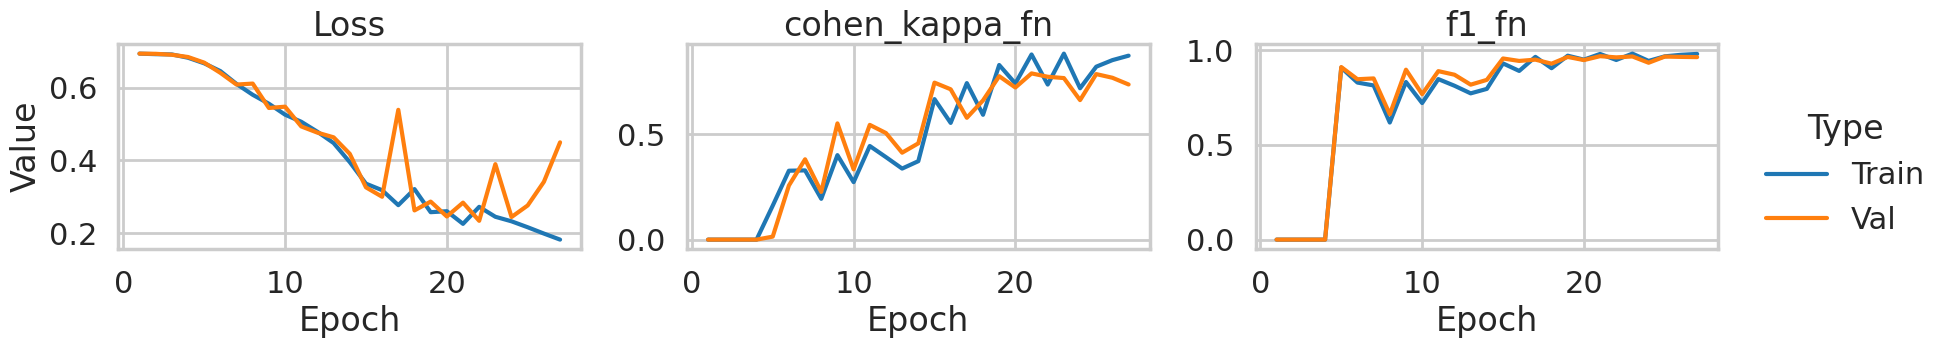

In [45]:
trainer_cnn_4.plot_epochs()

In [46]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2291 | Test cohen_kappa_fn: 0.7880 | Test f1_fn: 0.9651


#### Visualization

In [47]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

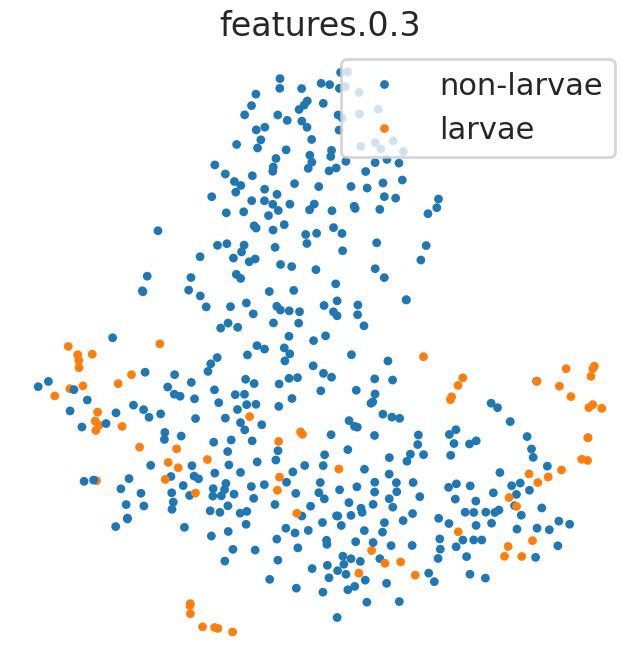

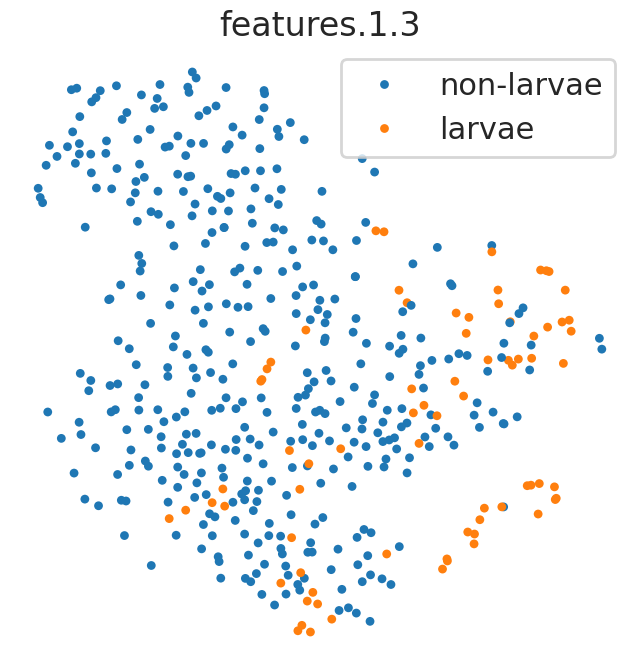

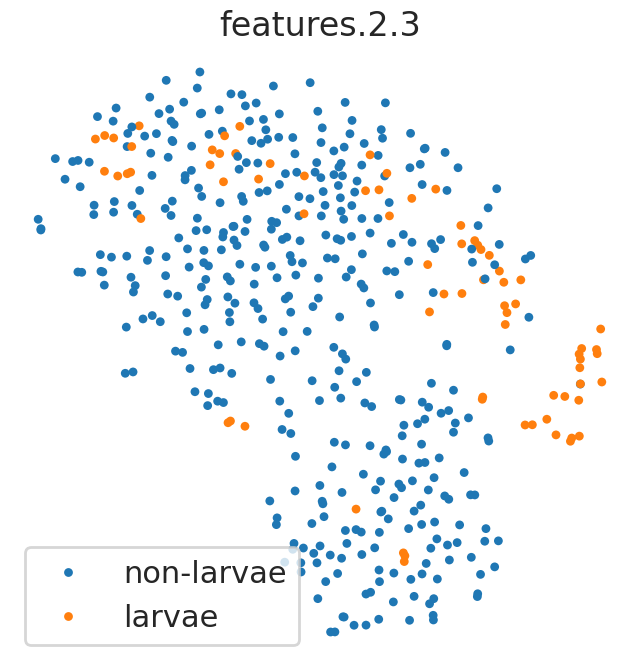

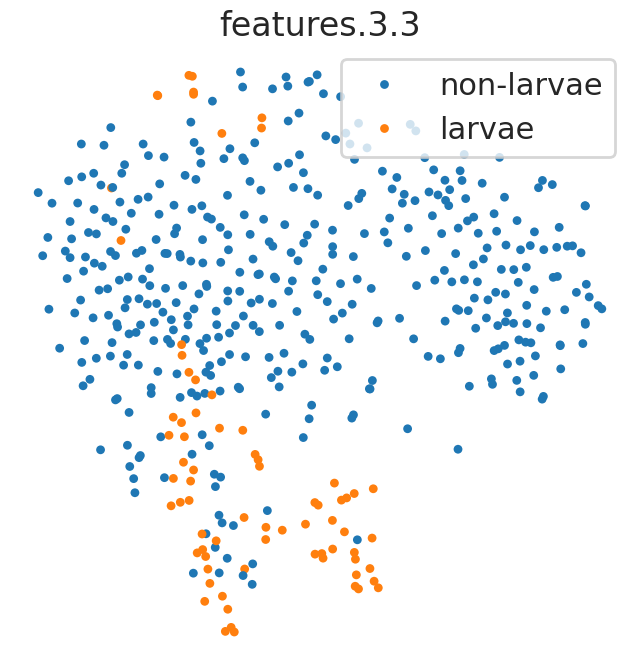

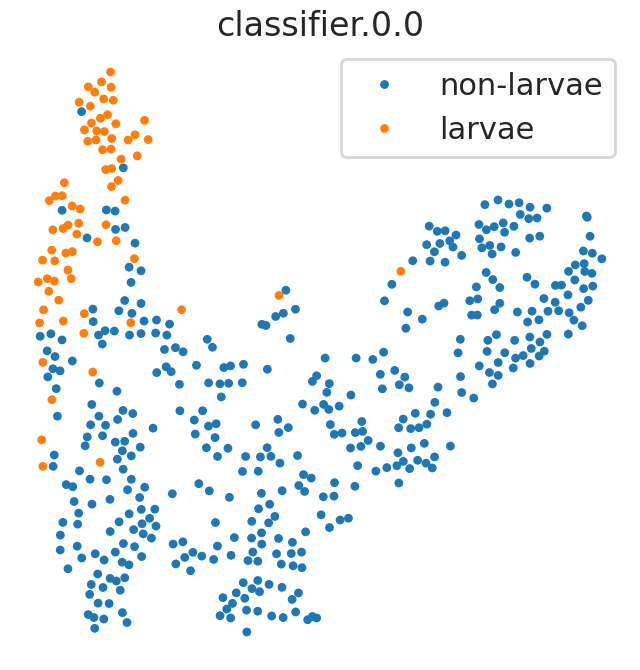

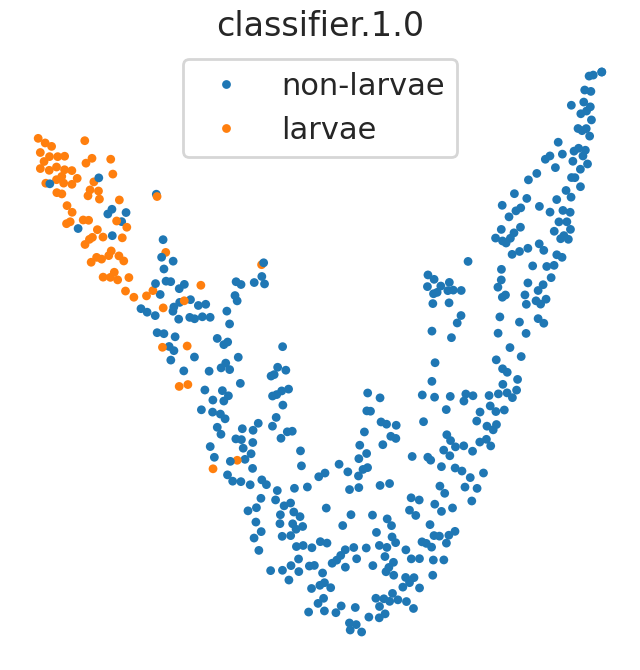

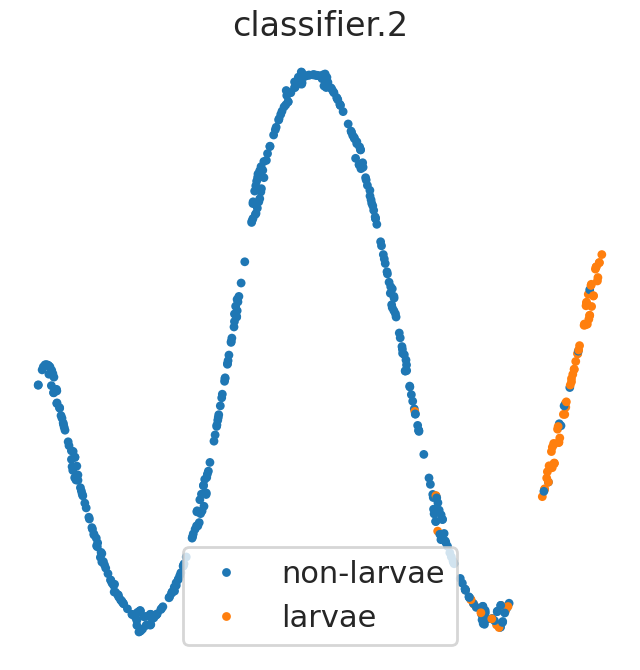

In [48]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


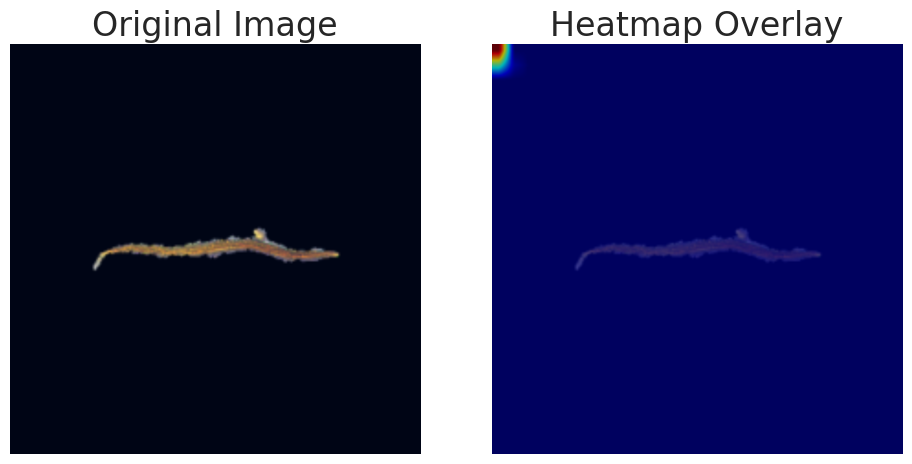

  Generating heatmap for Larvae...
  Predicted label is Larvae!


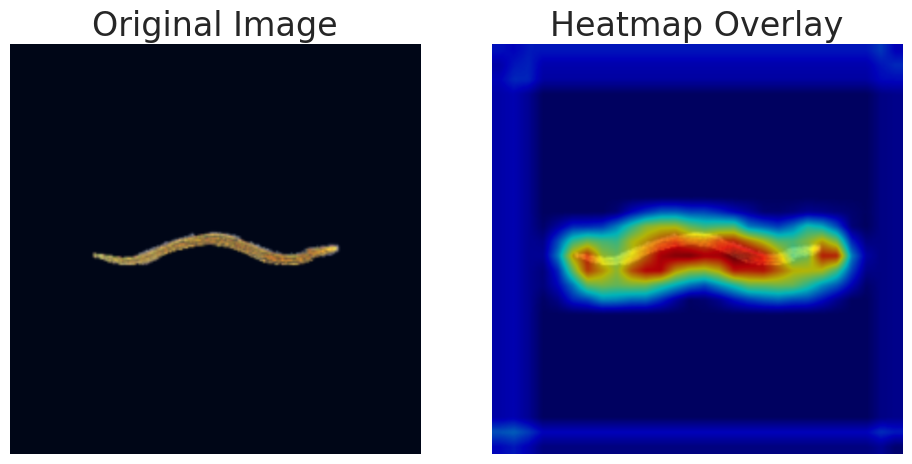

In [49]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [50]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128,16],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [51]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=eta_min)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [52]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0621 | Val cohen_kappa_fn: 0.1145 | Train f1_fn: 0.3100 | Val f1_fn: 0.4527
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6906 | Val Loss: 0.6917 | Train cohen_kappa_fn: 0.0965 | Val cohen_kappa_fn: 0.1274 | Train f1_fn: 0.4169 | Val f1_fn: 0.4986
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6839 | Val Loss: 0.6860 | Train cohen_kappa_fn: 0.1289 | Val cohen_kappa_fn: 0.1138 | Train f1_fn: 0.5142 | Val f1_fn: 0.5000
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6685 | Val Loss: 0.6694 | Train cohen_kappa_fn: 0.2471 | Val cohen_kappa_fn: 0.1944 | Train f1_fn: 0.7166 | Val f1_fn: 0.6963
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6367 | Val Loss: 0.6369 | Train cohen_kappa_fn: 0.2510 | Val cohen_kappa_fn: 0.2387 | Train f1_fn: 0.7356 | Val f1_fn: 0.7014
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6004 | Val Loss: 0.5801 | Train cohen_kappa_fn: 0.3112 | Val cohen_kappa_fn: 0.2955 | Train f1_fn: 0.7895 | Val f1_fn: 0.7679
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5344 | Val Loss: 0.5106 | Train cohen_kappa_fn: 0.2863 | Val cohen_kappa_fn: 0.3038 | Train f1_fn: 0.7608 | Val f1_fn: 0.7494
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4806 | Val Loss: 0.4430 | Train cohen_kappa_fn: 0.2847 | Val cohen_kappa_fn: 0.3065 | Train f1_fn: 0.7461 | Val f1_fn: 0.7454
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4105 | Val Loss: 0.3590 | Train cohen_kappa_fn: 0.4673 | Val cohen_kappa_fn: 0.5517 | Train f1_fn: 0.8628 | Val f1_fn: 0.8947
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3598 | Val Loss: 0.3559 | Train cohen_kappa_fn: 0.3492 | Val cohen_kappa_fn: 0.3616 | Train f1_fn: 0.7813 | Val f1_fn: 0.7838
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3067 | Val Loss: 0.2818 | Train cohen_kappa_fn: 0.4995 | Val cohen_kappa_fn: 0.5282 | Train f1_fn: 0.8723 | Val f1_fn: 0.8830
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2592 | Val Loss: 0.2815 | Train cohen_kappa_fn: 0.5041 | Val cohen_kappa_fn: 0.4961 | Train f1_fn: 0.8696 | Val f1_fn: 0.8661
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2652 | Val Loss: 0.2368 | Train cohen_kappa_fn: 0.7589 | Val cohen_kappa_fn: 0.7740 | Train f1_fn: 0.9565 | Val f1_fn: 0.9625
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2443 | Val Loss: 0.2356 | Train cohen_kappa_fn: 0.7260 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9474 | Val f1_fn: 0.9526
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2077 | Val Loss: 0.2755 | Train cohen_kappa_fn: 0.7691 | Val cohen_kappa_fn: 0.7393 | Train f1_fn: 0.9598 | Val f1_fn: 0.9593
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2304 | Val Loss: 0.2939 | Train cohen_kappa_fn: 0.7691 | Val cohen_kappa_fn: 0.7508 | Train f1_fn: 0.9598 | Val f1_fn: 0.9634
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1814 | Val Loss: 0.2908 | Train cohen_kappa_fn: 0.8138 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9674 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1729 | Val Loss: 0.4002 | Train cohen_kappa_fn: 0.8215 | Val cohen_kappa_fn: 0.7677 | Train f1_fn: 0.9708 | Val f1_fn: 0.9673
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1824 | Val Loss: 0.5570 | Train cohen_kappa_fn: 0.8636 | Val cohen_kappa_fn: 0.6667 | Train f1_fn: 0.9793 | Val f1_fn: 0.9570
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


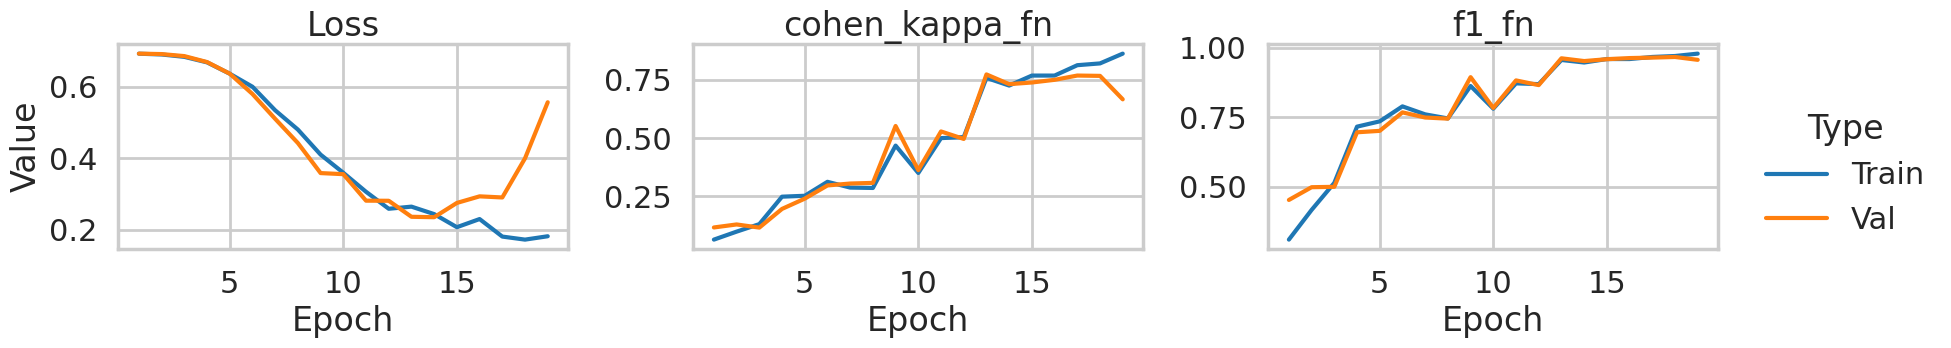

In [53]:
trainer_cnn_5.plot_epochs()

In [54]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2140 | Test cohen_kappa_fn: 0.7122 | Test f1_fn: 0.9479


#### Visualization

In [55]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

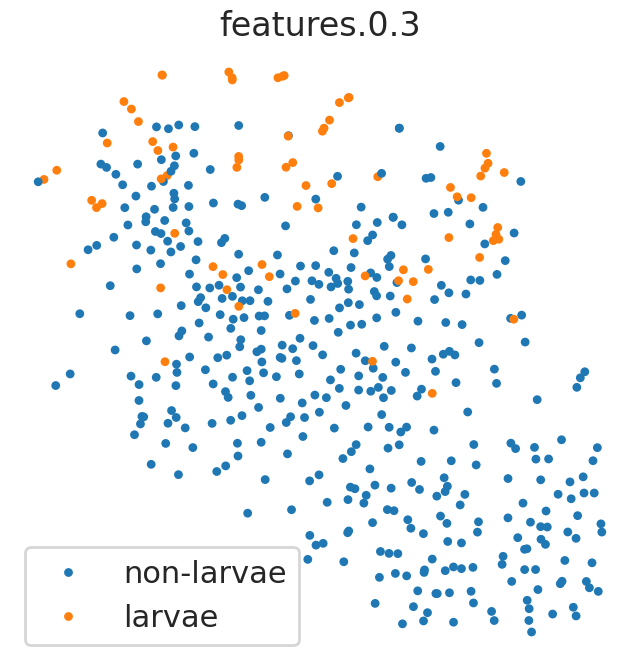

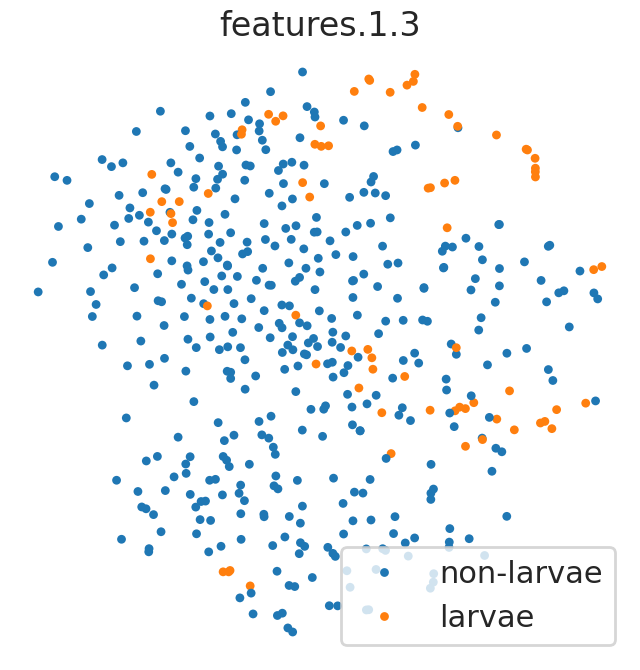

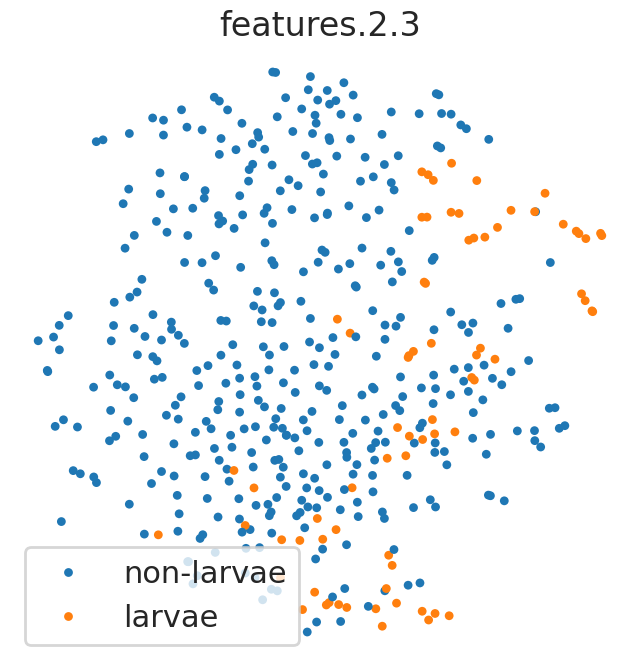

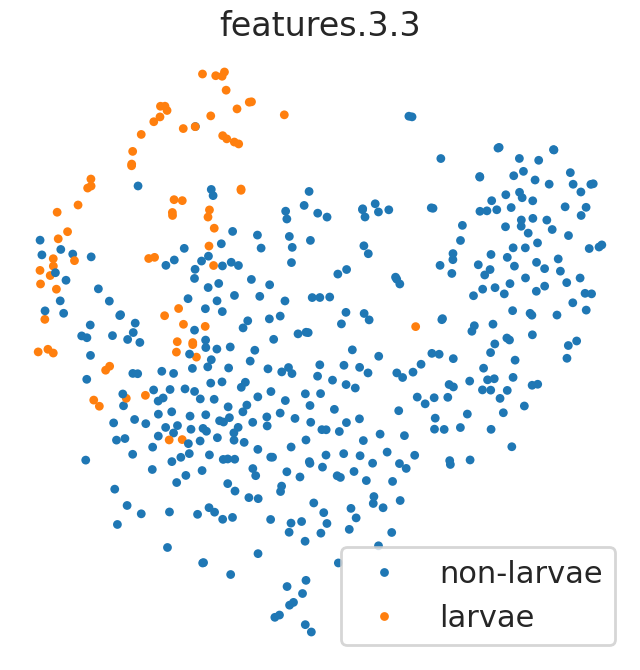

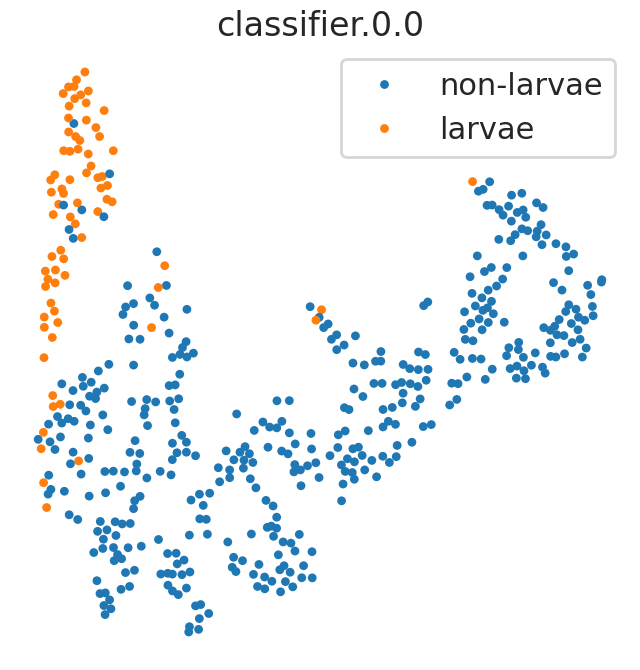

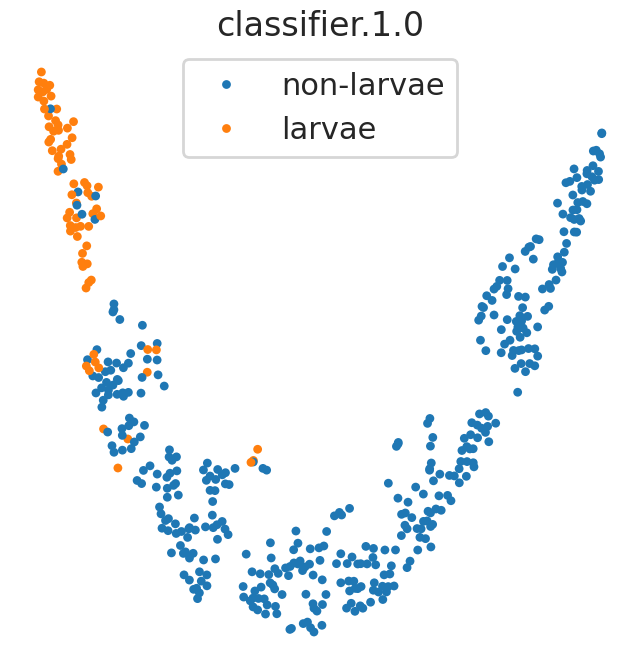

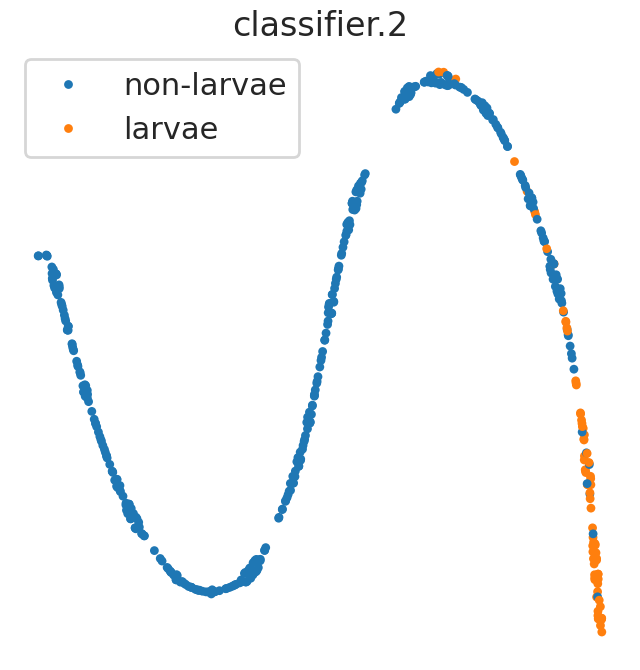

In [56]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


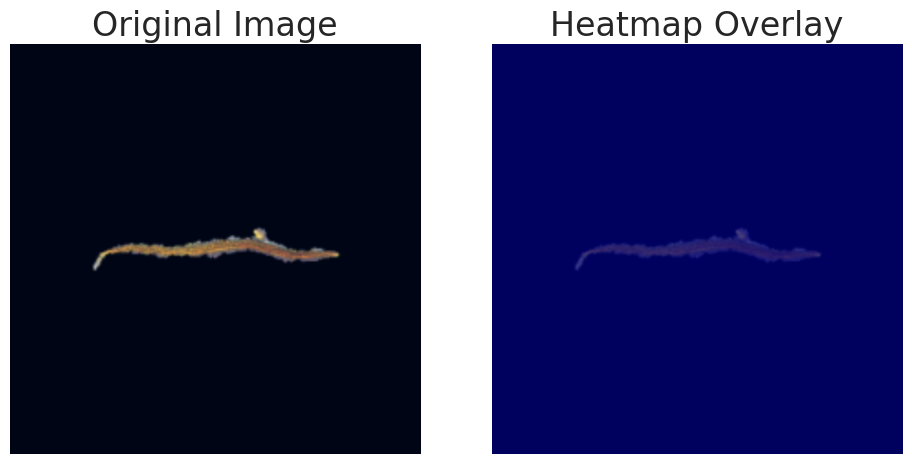

  Generating heatmap for Larvae...
  Predicted label is Larvae!


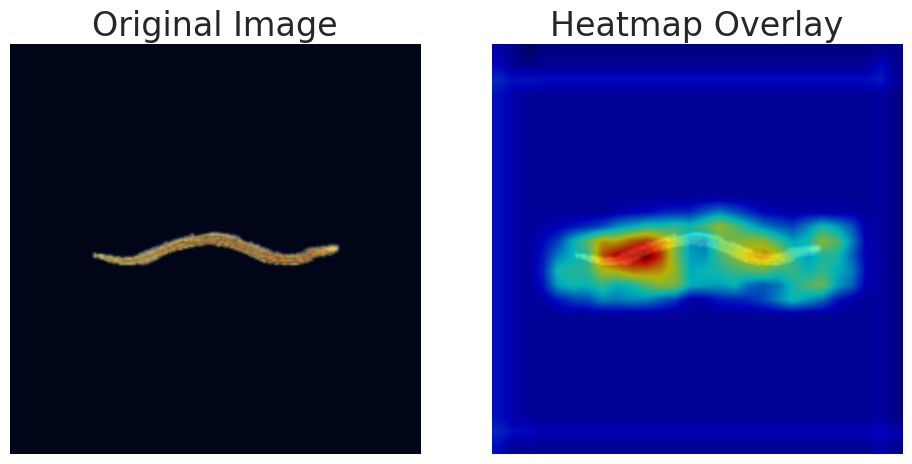

In [57]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [58]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [59]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=eta_min)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [60]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.7860 | Val Loss: 0.6954 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6847 | Val Loss: 0.6881 | Train cohen_kappa_fn: 0.0018 | Val cohen_kappa_fn: 0.0035 | Train f1_fn: 0.0118 | Val f1_fn: 0.0220
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6367 | Val Loss: 0.6620 | Train cohen_kappa_fn: 0.1887 | Val cohen_kappa_fn: 0.1065 | Train f1_fn: 0.7205 | Val f1_fn: 0.7463
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6015 | Val Loss: 0.6093 | Train cohen_kappa_fn: 0.0976 | Val cohen_kappa_fn: 0.1460 | Train f1_fn: 0.4274 | Val f1_fn: 0.5632
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5353 | Val Loss: 0.5470 | Train cohen_kappa_fn: 0.2267 | Val cohen_kappa_fn: 0.3228 | Train f1_fn: 0.6915 | Val f1_fn: 0.8201
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4813 | Val Loss: 0.4956 | Train cohen_kappa_fn: 0.3460 | Val cohen_kappa_fn: 0.3555 | Train f1_fn: 0.7961 | Val f1_fn: 0.8639
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4221 | Val Loss: 0.4161 | Train cohen_kappa_fn: 0.2553 | Val cohen_kappa_fn: 0.3566 | Train f1_fn: 0.7060 | Val f1_fn: 0.8009
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3801 | Val Loss: 0.4222 | Train cohen_kappa_fn: 0.1902 | Val cohen_kappa_fn: 0.2518 | Train f1_fn: 0.6127 | Val f1_fn: 0.6829
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.3642 | Val Loss: 0.4332 | Train cohen_kappa_fn: 0.2274 | Val cohen_kappa_fn: 0.2408 | Train f1_fn: 0.6601 | Val f1_fn: 0.6700
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.3819 | Val Loss: 0.3294 | Train cohen_kappa_fn: 0.6570 | Val cohen_kappa_fn: 0.6170 | Train f1_fn: 0.9362 | Val f1_fn: 0.9316
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3337 | Val Loss: 0.3329 | Train cohen_kappa_fn: 0.4345 | Val cohen_kappa_fn: 0.4260 | Train f1_fn: 0.8345 | Val f1_fn: 0.8261
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2870 | Val Loss: 0.2716 | Train cohen_kappa_fn: 0.7450 | Val cohen_kappa_fn: 0.7630 | Train f1_fn: 0.9561 | Val f1_fn: 0.9630
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2835 | Val Loss: 0.2989 | Train cohen_kappa_fn: 0.7728 | Val cohen_kappa_fn: 0.8115 | Train f1_fn: 0.9634 | Val f1_fn: 0.9726
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2550 | Val Loss: 0.2614 | Train cohen_kappa_fn: 0.7700 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9607 | Val f1_fn: 0.9687
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2119 | Val Loss: 0.3379 | Train cohen_kappa_fn: 0.7760 | Val cohen_kappa_fn: 0.7971 | Train f1_fn: 0.9660 | Val f1_fn: 0.9708
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2154 | Val Loss: 0.2482 | Train cohen_kappa_fn: 0.7736 | Val cohen_kappa_fn: 0.7831 | Train f1_fn: 0.9587 | Val f1_fn: 0.9668
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2295 | Val Loss: 0.2758 | Train cohen_kappa_fn: 0.7837 | Val cohen_kappa_fn: 0.7863 | Train f1_fn: 0.9639 | Val f1_fn: 0.9689
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2243 | Val Loss: 0.2534 | Train cohen_kappa_fn: 0.7990 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9652 | Val f1_fn: 0.9650
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1882 | Val Loss: 0.4245 | Train cohen_kappa_fn: 0.8167 | Val cohen_kappa_fn: 0.7592 | Train f1_fn: 0.9728 | Val f1_fn: 0.9675
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2105 | Val Loss: 0.2556 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9682 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1821 | Val Loss: 0.3897 | Train cohen_kappa_fn: 0.8815 | Val cohen_kappa_fn: 0.8194 | Train f1_fn: 0.9823 | Val f1_fn: 0.9745
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


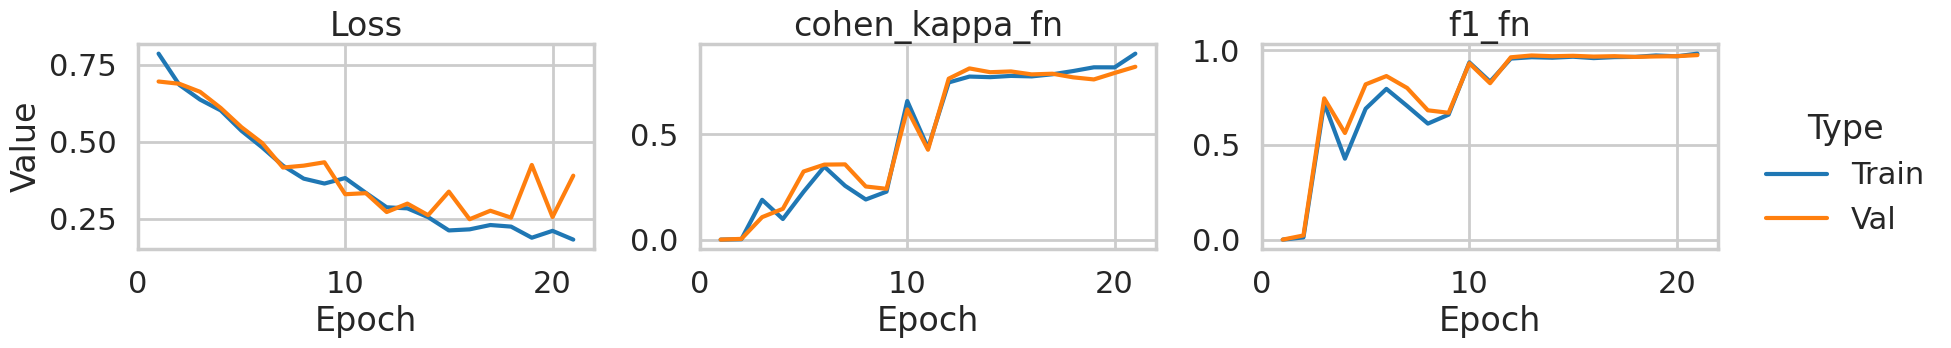

In [61]:
trainer_cnn_6.plot_epochs()

In [62]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2279 | Test cohen_kappa_fn: 0.8262 | Test f1_fn: 0.9728


#### Visualization

In [63]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

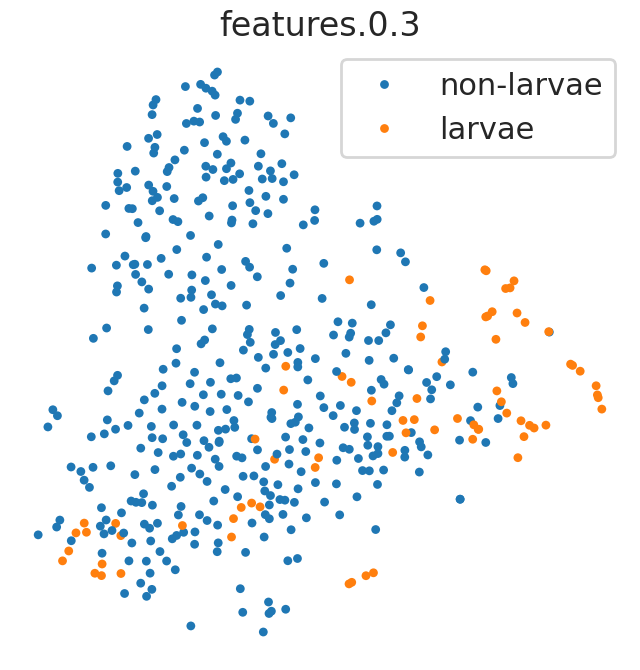

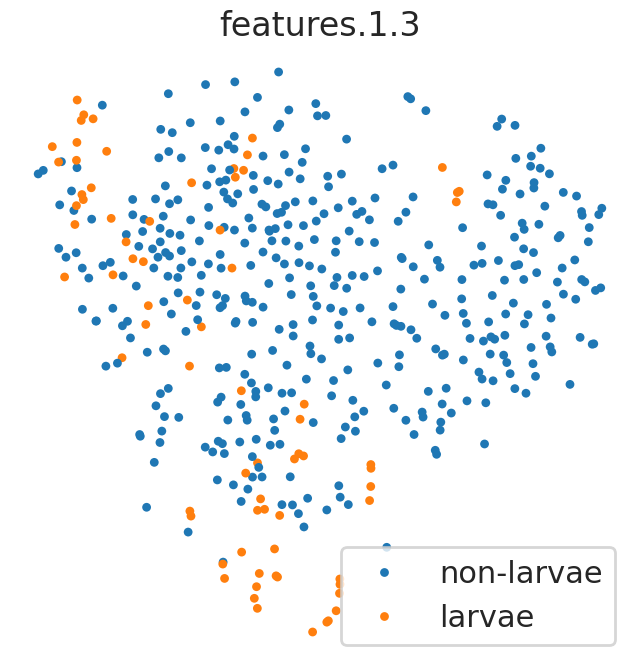

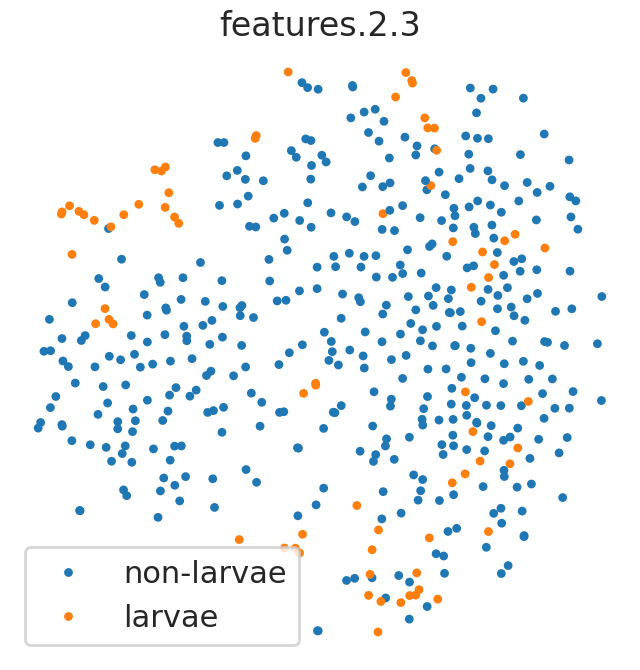

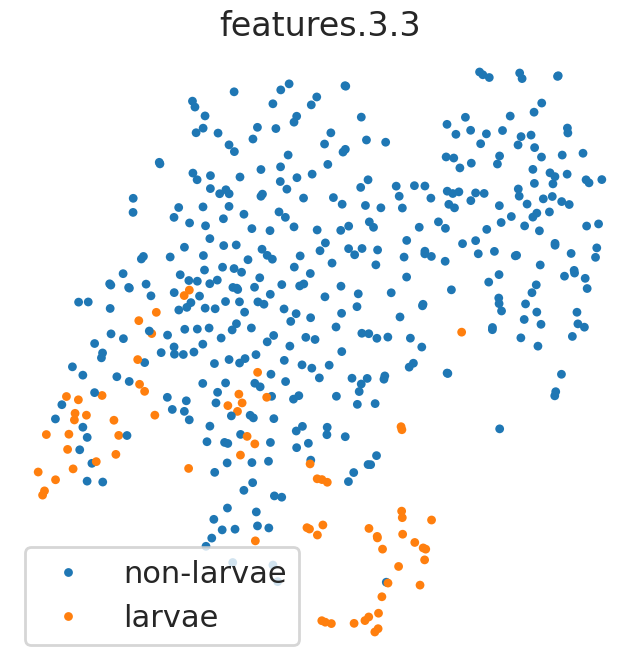

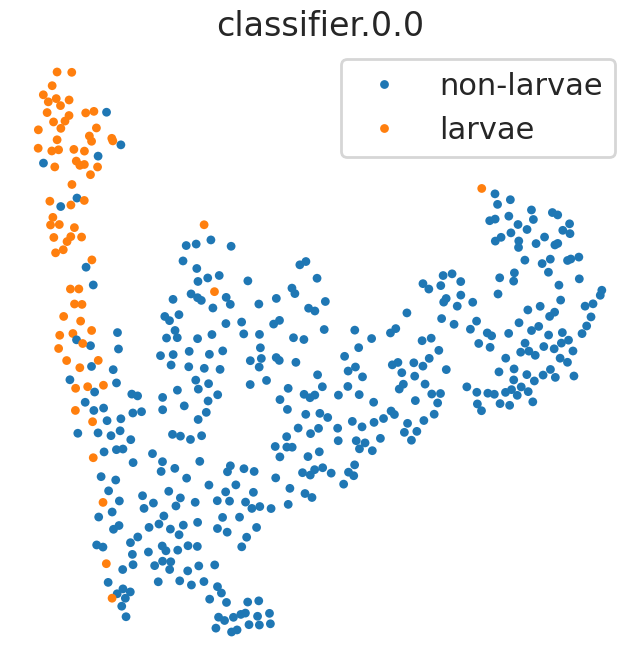

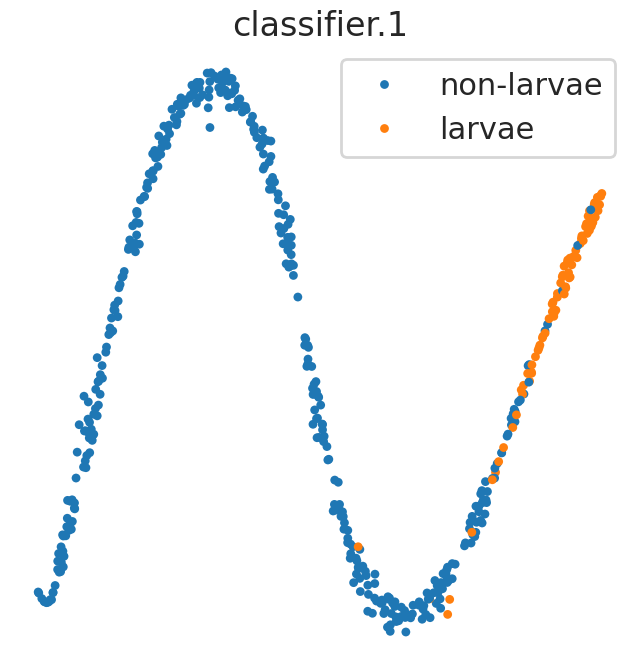

In [64]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


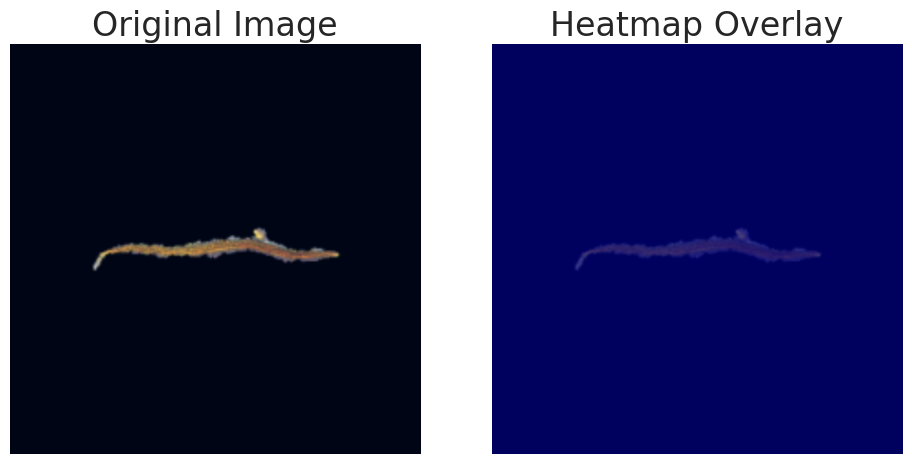

  Generating heatmap for Larvae...
  Predicted label is Larvae!


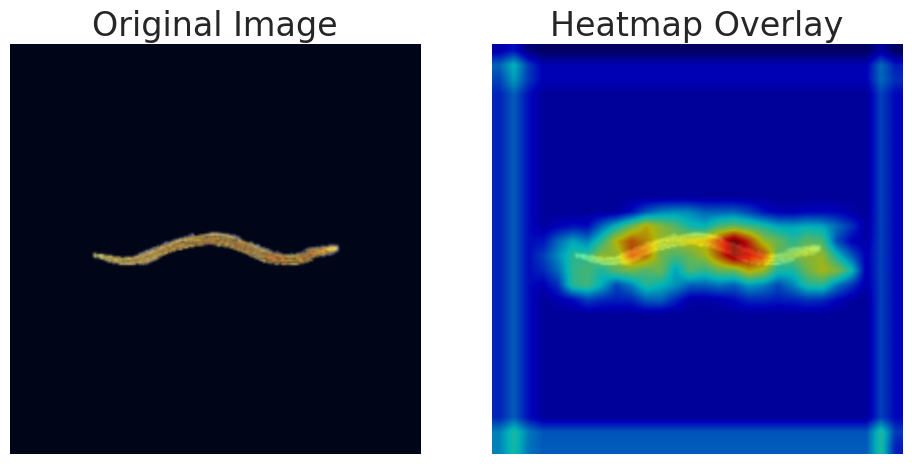

In [65]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [66]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[256],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [67]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=lr, weight_decay=weight_decay)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=eta_min)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [68]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 1.0298 | Val Loss: 0.6905 | Train cohen_kappa_fn: 0.0009 | Val cohen_kappa_fn: 0.0019 | Train f1_fn: 0.0059 | Val f1_fn: 0.0504
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6575 | Val Loss: 0.6715 | Train cohen_kappa_fn: 0.0236 | Val cohen_kappa_fn: 0.0603 | Train f1_fn: 0.1354 | Val f1_fn: 0.2911
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6179 | Val Loss: 0.6214 | Train cohen_kappa_fn: 0.1806 | Val cohen_kappa_fn: 0.2544 | Train f1_fn: 0.6503 | Val f1_fn: 0.8235
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5761 | Val Loss: 0.6025 | Train cohen_kappa_fn: 0.2984 | Val cohen_kappa_fn: 0.3466 | Train f1_fn: 0.8254 | Val f1_fn: 0.9242
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5143 | Val Loss: 0.5143 | Train cohen_kappa_fn: 0.2020 | Val cohen_kappa_fn: 0.3642 | Train f1_fn: 0.6621 | Val f1_fn: 0.8554
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4923 | Val Loss: 0.4693 | Train cohen_kappa_fn: 0.2874 | Val cohen_kappa_fn: 0.4476 | Train f1_fn: 0.7539 | Val f1_fn: 0.8863
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4609 | Val Loss: 0.5314 | Train cohen_kappa_fn: 0.5563 | Val cohen_kappa_fn: 0.5285 | Train f1_fn: 0.9283 | Val f1_fn: 0.9433
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.4422 | Val Loss: 0.4492 | Train cohen_kappa_fn: 0.5975 | Val cohen_kappa_fn: 0.5429 | Train f1_fn: 0.9265 | Val f1_fn: 0.9321
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3892 | Val Loss: 0.3753 | Train cohen_kappa_fn: 0.5851 | Val cohen_kappa_fn: 0.6591 | Train f1_fn: 0.9142 | Val f1_fn: 0.9462
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3383 | Val Loss: 0.3459 | Train cohen_kappa_fn: 0.6275 | Val cohen_kappa_fn: 0.6786 | Train f1_fn: 0.9269 | Val f1_fn: 0.9478
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3266 | Val Loss: 0.3093 | Train cohen_kappa_fn: 0.6000 | Val cohen_kappa_fn: 0.6160 | Train f1_fn: 0.9101 | Val f1_fn: 0.9243
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3315 | Val Loss: 0.3053 | Train cohen_kappa_fn: 0.7082 | Val cohen_kappa_fn: 0.7296 | Train f1_fn: 0.9473 | Val f1_fn: 0.9573
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2944 | Val Loss: 0.2986 | Train cohen_kappa_fn: 0.7184 | Val cohen_kappa_fn: 0.7296 | Train f1_fn: 0.9497 | Val f1_fn: 0.9573
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2721 | Val Loss: 0.2790 | Train cohen_kappa_fn: 0.7051 | Val cohen_kappa_fn: 0.6507 | Train f1_fn: 0.9435 | Val f1_fn: 0.9323
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2755 | Val Loss: 0.3560 | Train cohen_kappa_fn: 0.4916 | Val cohen_kappa_fn: 0.3908 | Train f1_fn: 0.8650 | Val f1_fn: 0.8088
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3066 | Val Loss: 0.2972 | Train cohen_kappa_fn: 0.8065 | Val cohen_kappa_fn: 0.7206 | Train f1_fn: 0.9704 | Val f1_fn: 0.9576
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2171 | Val Loss: 0.2577 | Train cohen_kappa_fn: 0.6820 | Val cohen_kappa_fn: 0.6284 | Train f1_fn: 0.9358 | Val f1_fn: 0.9261
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2180 | Val Loss: 0.4047 | Train cohen_kappa_fn: 0.7791 | Val cohen_kappa_fn: 0.7373 | Train f1_fn: 0.9695 | Val f1_fn: 0.9638
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1984 | Val Loss: 0.2589 | Train cohen_kappa_fn: 0.7902 | Val cohen_kappa_fn: 0.7288 | Train f1_fn: 0.9636 | Val f1_fn: 0.9551
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2097 | Val Loss: 0.2666 | Train cohen_kappa_fn: 0.8089 | Val cohen_kappa_fn: 0.7653 | Train f1_fn: 0.9666 | Val f1_fn: 0.9651
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1831 | Val Loss: 0.3417 | Train cohen_kappa_fn: 0.8707 | Val cohen_kappa_fn: 0.7612 | Train f1_fn: 0.9800 | Val f1_fn: 0.9653
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1938 | Val Loss: 0.2201 | Train cohen_kappa_fn: 0.7338 | Val cohen_kappa_fn: 0.7475 | Train f1_fn: 0.9479 | Val f1_fn: 0.9590
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1766 | Val Loss: 0.2364 | Train cohen_kappa_fn: 0.7784 | Val cohen_kappa_fn: 0.7730 | Train f1_fn: 0.9594 | Val f1_fn: 0.9649
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1525 | Val Loss: 0.2261 | Train cohen_kappa_fn: 0.7631 | Val cohen_kappa_fn: 0.7590 | Train f1_fn: 0.9563 | Val f1_fn: 0.9631
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1562 | Val Loss: 0.2360 | Train cohen_kappa_fn: 0.7631 | Val cohen_kappa_fn: 0.7590 | Train f1_fn: 0.9563 | Val f1_fn: 0.9631
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1333 | Val Loss: 0.2883 | Train cohen_kappa_fn: 0.8291 | Val cohen_kappa_fn: 0.7550 | Train f1_fn: 0.9705 | Val f1_fn: 0.9632
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1463 | Val Loss: 0.2967 | Train cohen_kappa_fn: 0.8153 | Val cohen_kappa_fn: 0.7550 | Train f1_fn: 0.9682 | Val f1_fn: 0.9632
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


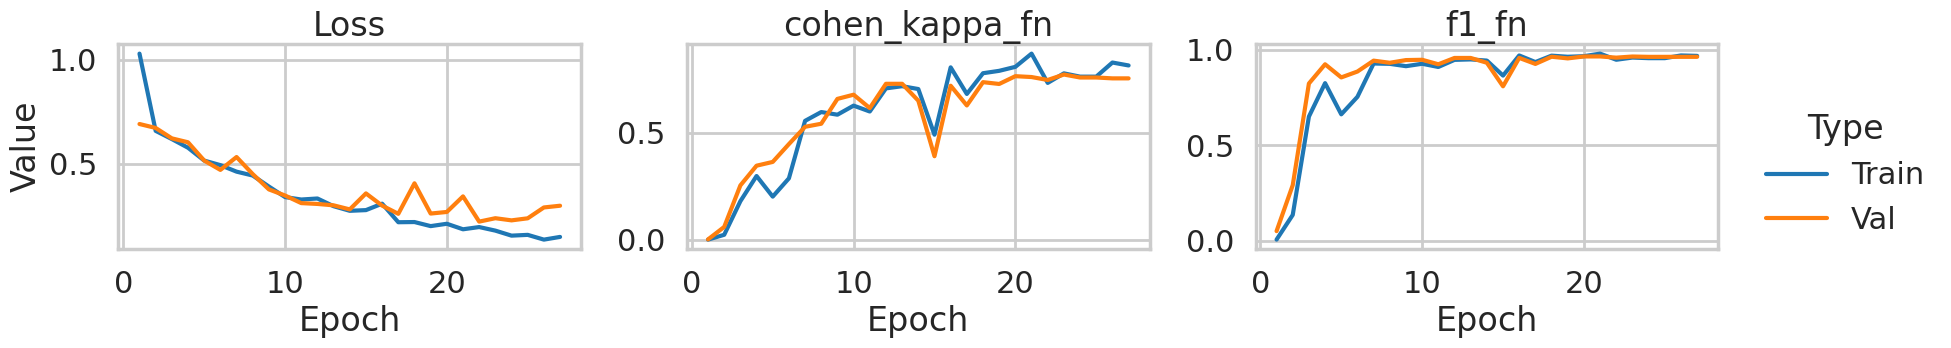

In [69]:
trainer_cnn_7.plot_epochs()

In [70]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1998 | Test cohen_kappa_fn: 0.7858 | Test f1_fn: 0.9652


#### Visualization

In [71]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

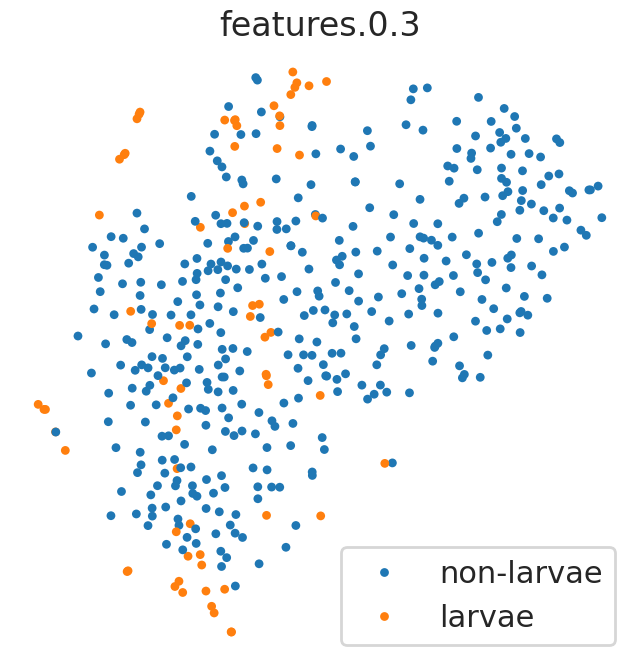

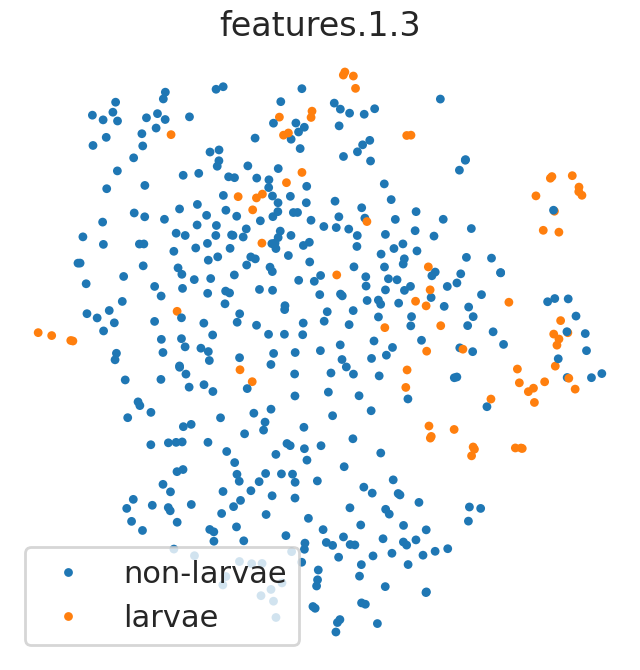

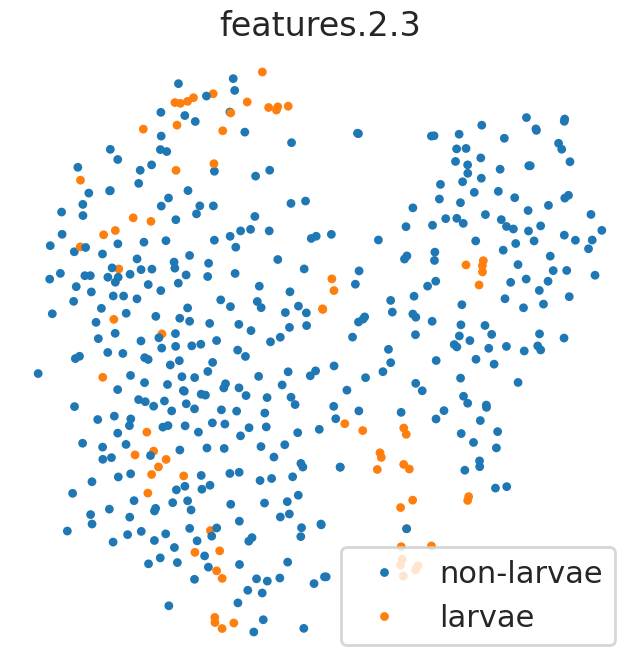

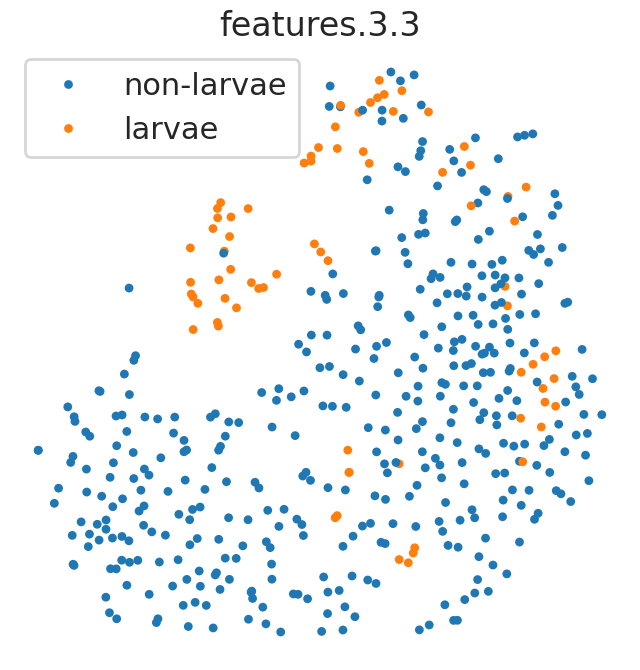

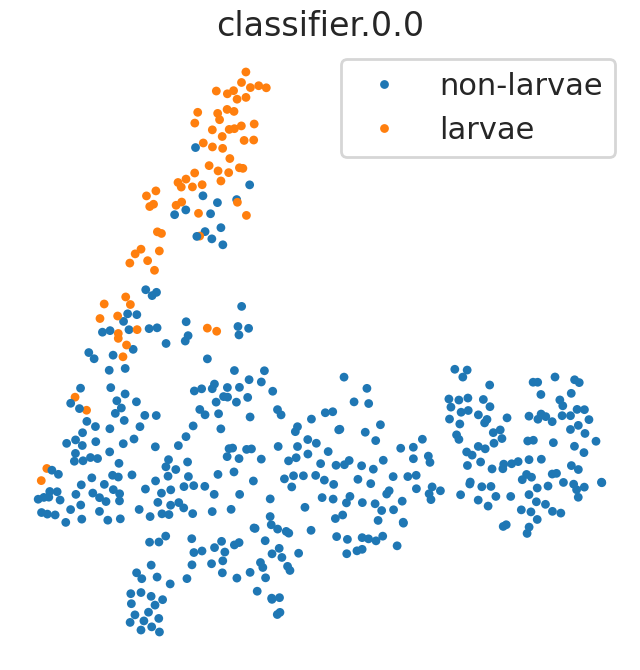

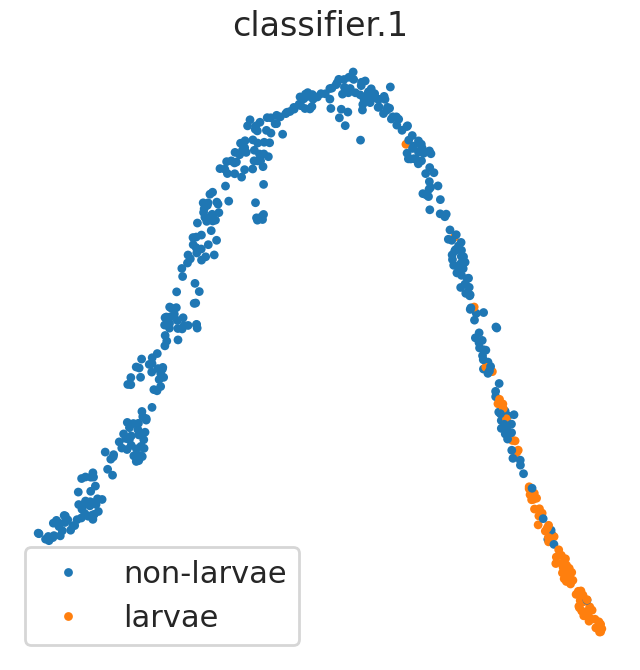

In [72]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


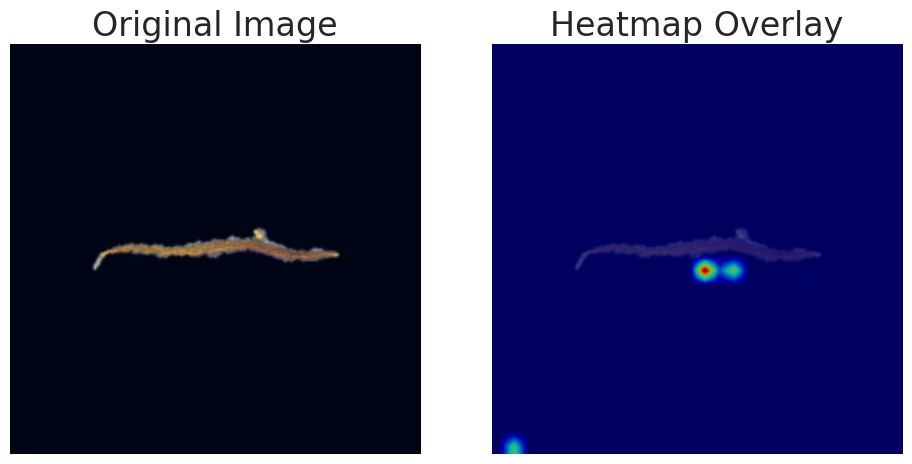

  Generating heatmap for Larvae...
  Predicted label is Larvae!


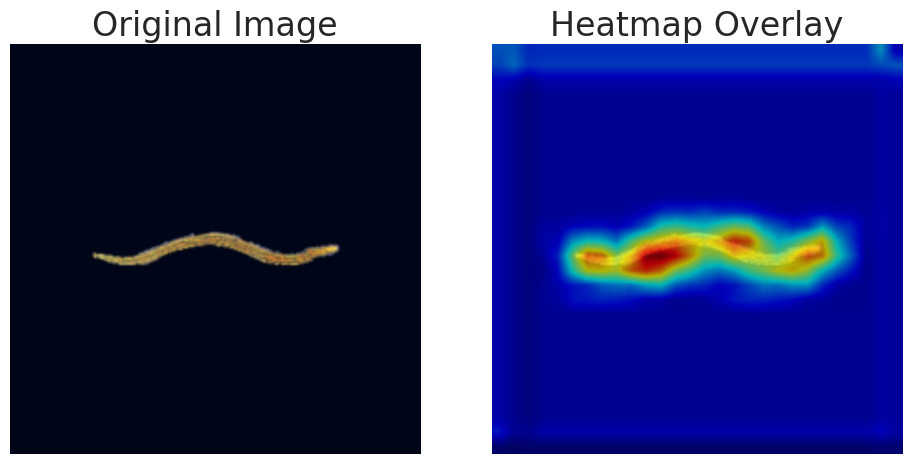

In [73]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break